# **PROJET SEATTLE ENERGY BENCHMARKING**
## Notebook 02 : **Analyse univariée**

---

### Identité du document
* **Statut :** Phase 1 (exploration univariée)
* **Date de création :** 01 Janvier 2026
* **Dernière mise à jour :** 01 Janvier 2026
* **Dépendances notebooks** : notebook_0 et notebook_1

### Description
Ce notebook constitue une **analyse univariée** des données de consommation énergétique et des émissions de CO₂ de la ville de Seattle.  
L'objectif est de **comprendre la distribution de chaque variable** dataset pour la construction d’un futur modèle de Machine Learning.

> **Philosophie :** "Connaître ses données avant de construire un modèle est la clé pour éviter les biais et les erreurs de prédiction."

### Objectifs principaux
1. **Explorer** les variables numériques et catégorielles individuellement.
2. **Analyser** les distributions statistiques (histogrammes, boxplots, stats descriptives).
3. **Préparer** une synthèse des transformations à prévoir pour le ML (normalisation, encodage).

### Dépendances critiques
* `pandas`, `numpy` : Manipulation et analyse de données.
* `matplotlib`, `seaborn` : Visualisations graphiques.

### LIVRABLES
1. **Tableau des statistiques descriptives** : moyenne, médiane, écart-type, min/max.
2. **Graphiques de distribution** : histogrammes et boxplots pour chaque variable.
3. **Rapport de synthèse** : observations sur les valeurs manquantes, outliers et recommandations pour la préparation des données.


# 📚 Table des matières

- [Section 0 : Importation et chargement](#section-0--importation-et-chargement)
- [Section 1 : Vue globale du dataset](#section-1--vue-globale-du-dataset)
- [Section 2 : Analyse de la variable cible : `TotalGHGEmissions`](#section-2--analyse-de-la-variable-cible--totalghgemissions)
- [Section 3 : Analyse descriptive des variables quantitatives](#section-3--analyse-descriptive-des-variables-quantitatives)
- [Section 4 : Analyse des variables qualitatives](#section-4--analyse-des-variables-qualitatives)

> **Note :** Les liens de la table des matières peuvent ne pas fonctionner selon votre éditeur. Utilisez plutôt l’outline ou la navigation intégrée (VSCode, JupyterLab, etc.) pour naviguer dans les sections.

# Section 0 : Importation et chargement

## Importation des packages

In [ ]:
import logging
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, normaltest, skew, kurtosis
import warnings
import math
import pylab as py
import statsmodels.api as sm

import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))


from data.load_data import load_data_raw
from utils.config_loader import load_config, create_directories
from utils.eda_logger import setup_eda_logger

# pour voir toutes les colonnes
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_row', 100)

# style de titres
font = {
    'family': 'Arial',
    'color': 'darkred',
    'weight': 'bold',
    'size': 30,
}
 


In [209]:
# Chargement de la configuration principale (Hydra)
cfg = load_config()

# Initialisation du logger
setup_eda_logger(cfg)
logger = logging.getLogger(__name__)

# Création des dossiers nécessaires à l'exécution (raw, interim, processed, reports, etc.)
create_directories(cfg)
# Chargement des données brutes
df_raw = load_data_raw(cfg)

# Validation dimensions
n_rows, n_cols = df_raw.shape
logger.info(f"Dataset chargé ({n_rows} lignes, {n_cols} colonnes)")



2026-01-03 11:57:39,191 - utils.config_loader - INFO - Configuration 'config' chargée (project_root=C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2)
2026-01-03 11:57:39,200 - utils.config_loader - INFO - Répertoire prêt : C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\data\raw
2026-01-03 11:57:39,203 - utils.config_loader - INFO - Répertoire prêt : C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\data\interim
2026-01-03 11:57:39,206 - utils.config_loader - INFO - Répertoire prêt : C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\data\processed
2026-01-03 11:57:39,209 - utils.config_loader - INFO - Répertoire prêt : C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\figures
2026-01-03 11:57:39,209 - utils.config_loader - INFO - Répertoire prêt : C:\Users\DELL\Desktop\ise2\Informatique\ML 1

# Section 1 : Vue globale du dataset

In [91]:
# Aperçu des premières lignes
print("="*80)
print("CINQ PREMIERES LIGNES DU DATASET")
print("="*80)
df_raw.head(5)

CINQ PREMIERES LIGNES DU DATASET


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [111]:
#  Aperçu général
print("="*80)
print("INFORMATIONS GENERALES DU DATASET")
print("="*80)

df_raw.columns

INFORMATIONS GENERALES DU DATASET


Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

In [110]:
#  Aperçu général
print("="*80)
print("INFORMATIONS GENERALES DU DATASET")
print("="*80)

df_raw.shape

INFORMATIONS GENERALES DU DATASET


(3376, 46)

In [112]:
#  Aperçu général
print("="*80)
print("INFORMATIONS GENERALES DU DATASET")
print("="*80)

df_raw.info()

INFORMATIONS GENERALES DU DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null  

In [115]:
#  Types de variables
print("\n" + "="*80)
print("TYPES DES VARIABLES DU DATASET BRUT")
print("="*80)
print(df_raw.dtypes.value_counts())


TYPES DES VARIABLES DU DATASET BRUT
float64    22
object     15
int64       8
bool        1
Name: count, dtype: int64


In [117]:
print("\n" + "="*80)
print("TYPES DES VARIABLES DU DATASET BRUT DÉTAILLÉS")
print("="*80)

print("\nTypes des variables :")
print(df_raw.dtypes)


TYPES DES VARIABLES DU DATASET BRUT DÉTAILLÉS

Types des variables :
OSEBuildingID                        int64
DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
PropertyName                        object
Address                             object
City                                object
State                               object
ZipCode                            float64
TaxParcelIdentificationNumber       object
CouncilDistrictCode                  int64
Neighborhood                        object
Latitude                           float64
Longitude                          float64
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType     

# Section 2 : Analyse de la variable cible : `TotalGHGEmissions`

**Objectif :**  
Produire une **vue complète et hiérarchisée** de la variable cible, en examinant sa **distribution, ses statistiques descriptives et ses valeurs extrêmes**, afin de préparer la construction du modèle de Machine Learning.

**Questions clés :**  
1. Quelle est la **distribution** de `TotalGHGEmissions` (histogramme, densité, asymétrie) ?  
2. Quelles sont les **valeurs centrales** : moyenne, médiane, quartiles ?    
3. Faut-il **transformer** la variable (log, normalisation) pour réduire la skewness ou l’influence des outliers ?  
4. Existe-t-il des **patterns particuliers** dans `TotalGHGEmissions` selon des variables catégorielles (ex: BuildingType, PrimaryUse) ?  

### Statistiques descriptives

In [122]:
print("\n" + "="*80)
print("Analyse univariée de la variable cible : TotalGHGEmissions")
print("="*80)
    
print('\n TotalGHGEmissions')
print('----'*10)
print("moy:", df_raw['TotalGHGEmissions'].mean())
print("med:", df_raw['TotalGHGEmissions'].median())
print("std:", df_raw['TotalGHGEmissions'].std(ddof=0))
print("skw:", df_raw['TotalGHGEmissions'].skew())
print("kur:", df_raw['TotalGHGEmissions'].kurtosis())


Analyse univariée de la variable cible : TotalGHGEmissions

 TotalGHGEmissions
----------------------------------------
moy: 119.72397089397089
med: 33.92
std: 538.7522038990847
skw: 19.481874921458164
kur: 474.89222328895323


In [127]:
print("\n" + "="*40)
print("Quartiles")
print("="*40)

print('\n TotalGHGEmissions')
print('----'*10)

print(f"  Q1 (25%): {df_raw['TotalGHGEmissions'].quantile(0.25):.2f} tonnes CO2")
print(f"  Q2 (50%): {df_raw['TotalGHGEmissions'].quantile(0.50):.2f} tonnes CO2")
print(f"  Q3 (75%): {df_raw['TotalGHGEmissions'].quantile(0.75):.2f} tonnes CO2")
print(f"  IQR (Interquartile): {df_raw['TotalGHGEmissions'].quantile(0.75) - df_raw['TotalGHGEmissions'].quantile(0.25):.2f} tonnes CO2")


Quartiles

 TotalGHGEmissions
----------------------------------------
  Q1 (25%): 9.50 tonnes CO2
  Q2 (50%): 33.92 tonnes CO2
  Q3 (75%): 93.94 tonnes CO2
  IQR (Interquartile): 84.44 tonnes CO2


### Test de normalité et visualisation

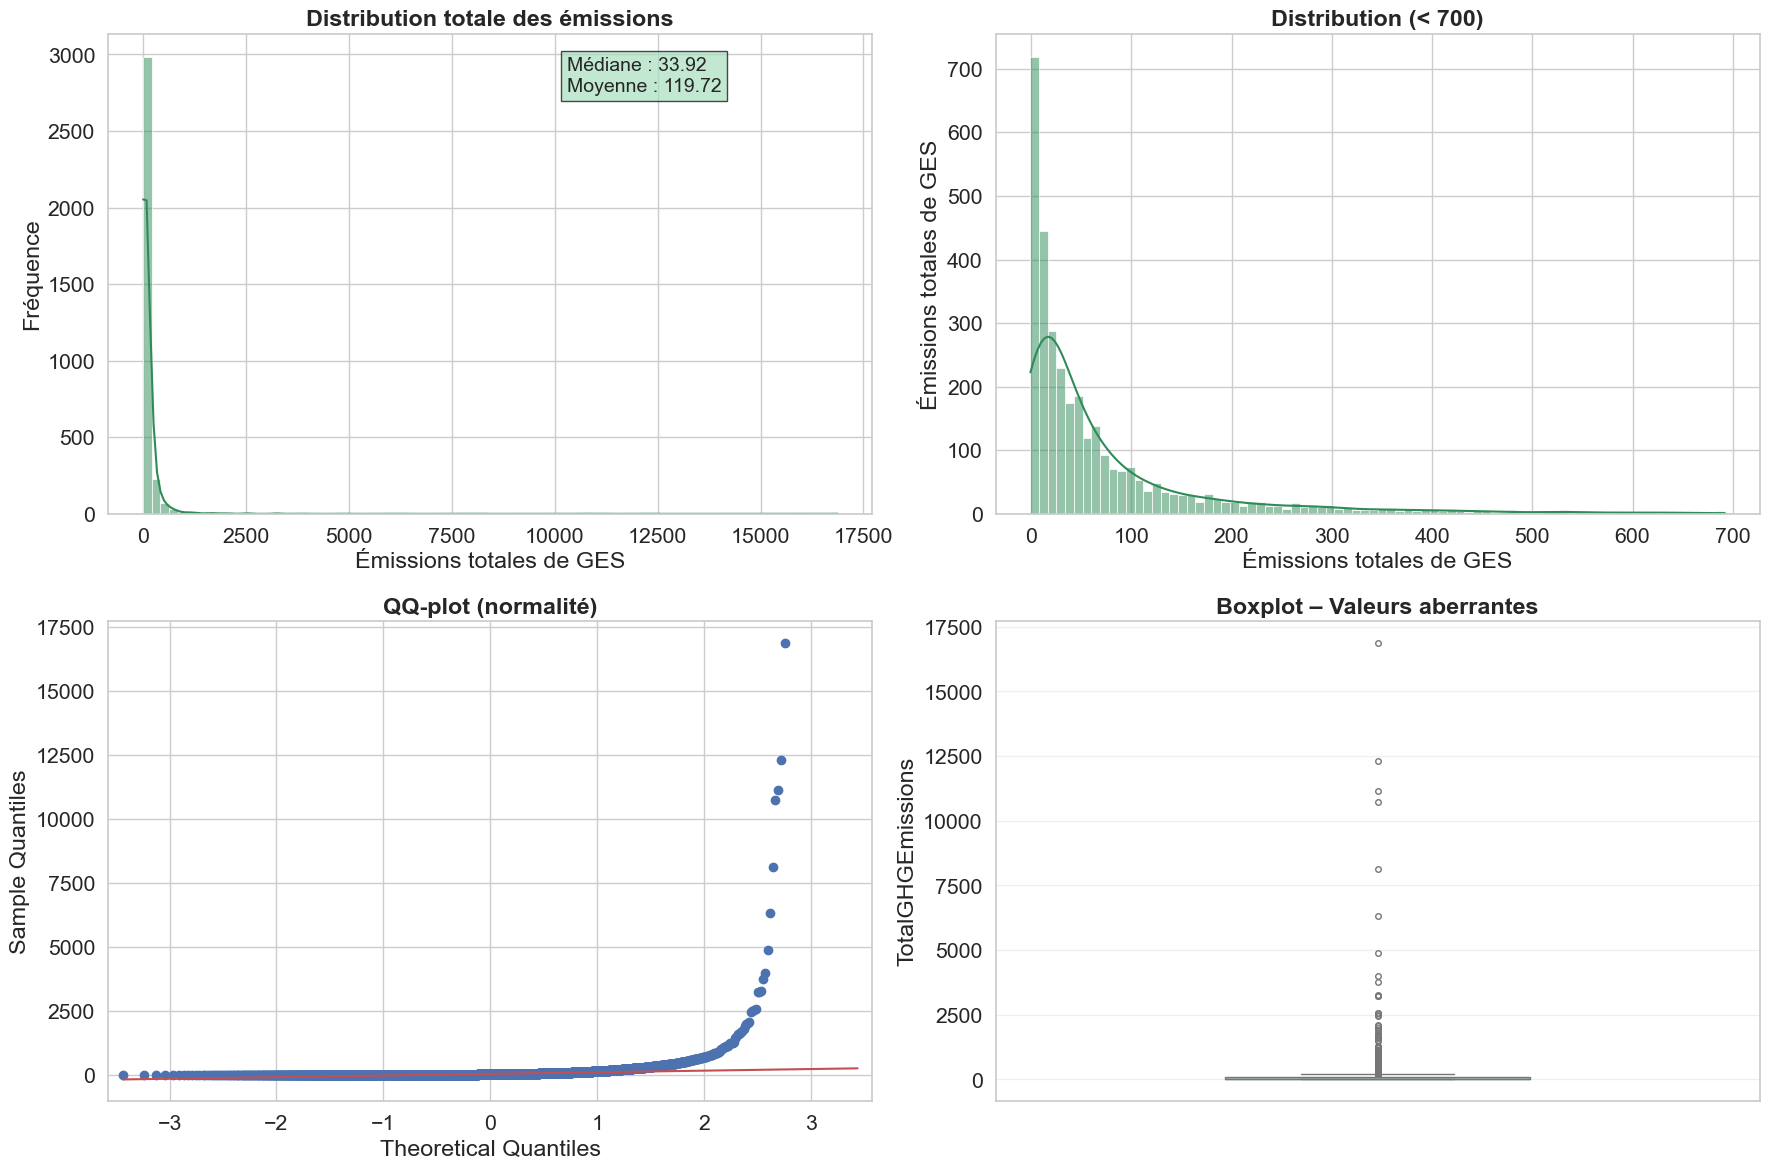

In [210]:
main_color = "#2E8B57"   # SeaGreen
box_color = "#A9DFBF"    # Light green

sns.set(
    rc={'figure.figsize': (18, 12)},
    font_scale=1.4,
    style="whitegrid"
)

fig, axes = plt.subplots(2, 2)


#  Histogramme global

sns.histplot(
    df_raw,
    x='TotalGHGEmissions',
    kde=True,
    bins=80,
    color=main_color,
    ax=axes[0, 0]
)

axes[0, 0].text(
    0.60, 0.88,
    f"Médiane : {df_raw['TotalGHGEmissions'].median():.2f}\n"
    f"Moyenne : {df_raw['TotalGHGEmissions'].mean():.2f}",
    transform=axes[0, 0].transAxes,
    fontsize=14,
    bbox=dict(facecolor=box_color, alpha=0.7, edgecolor='black')
)

axes[0, 0].set_title("Distribution totale des émissions", fontweight='bold')
axes[0, 0].set_xlabel("Émissions totales de GES")
axes[0, 0].set_ylabel("Fréquence")

#  Histogramme tronqué

sns.histplot(
    df_raw[df_raw['TotalGHGEmissions'] < 700],
    x='TotalGHGEmissions',
    kde=True,
    bins=80,
    color=main_color,
    ax=axes[0, 1]
)

axes[0, 1].set_title("Distribution (< 700)", fontweight='bold')
axes[0, 1].set_xlabel("Émissions totales de GES")
axes[0, 1].set_ylabel("Fréquence")

#  QQ-plot

sm.qqplot(
    df_raw['TotalGHGEmissions'],
    line='q',
    ax=axes[1, 0],
    color=main_color
)

axes[1, 0].set_title("QQ-plot (normalité)", fontweight='bold')

# Boxplot

sns.boxplot(
    y=df_raw['TotalGHGEmissions'],
    ax=axes[1, 1],
    color=box_color,
    width=0.4,
    fliersize=4
)

axes[1, 1].set_title("Boxplot – Valeurs aberrantes", fontweight='bold')
axes[0, 1].set_ylabel("Émissions totales de GES")
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [211]:

from scipy.stats import normaltest, shapiro, kstest, anderson, jarque_bera

print(' \nTests sur la variable TotalGHGEmissions')
print('----'*10)

target = df_raw['TotalGHGEmissions'].dropna()
log_target = np.log1p(target)

alpha = 0.05


# Fonction d'interprétation

def interpret_test(p_value, alpha=0.05):
    return "Distribution compatible avec la normalité (H0 non rejetée)" \
        if p_value > alpha else "Distribution non normale (H0 rejetée)"


# D’Agostino-Pearson (normaltest)
print("\n" + "=" * 60)
stat, p = normaltest(target)
print("TotalGHGEmissions Agostino-Pearson")
print(f"Statistic = {stat:.3f}, p-value = {p:.3e}")
print(interpret_test(p))
print("=" * 60)


# Shapiro

if len(target) < 5000:
    stat, p = shapiro(target)
    print("TotalGHGEmissions Shapiro")
    print(f"Statistic = {stat:.3f}, p-value = {p:.3e}")
    print(interpret_test(p))
else:
    print("Shapiro non exécuté : échantillon trop grand (>5000)")
print("=" * 60)


# Kolmogorov–Smirnov

# On compare avec la distribution normale standardisée
target_std = (target - target.mean()) / target.std()
stat, p = kstest(target_std, 'norm')
print("TotalGHGEmissions Kolmogorov–Smirnov")
print(f"Statistic = {stat:.3f}, p-value = {p:.3e}")
print(interpret_test(p))
print("=" * 60)


# Jarque-Bera

stat, p = jarque_bera(target)
print("TotalGHGEmissions Jarque-Bera")
print(f"Statistic = {stat:.3f}, p-value = {p:.3e}")
print(interpret_test(p))
print("=" * 60)

 
Tests sur la variable TotalGHGEmissions
----------------------------------------

TotalGHGEmissions Agostino-Pearson
Statistic = 7337.199, p-value = 0.000e+00
Distribution non normale (H0 rejetée)
TotalGHGEmissions Shapiro
Statistic = 0.146, p-value = 4.786e-82
Distribution non normale (H0 rejetée)
TotalGHGEmissions Kolmogorov–Smirnov
Statistic = 0.412, p-value = 0.000e+00
Distribution non normale (H0 rejetée)
TotalGHGEmissions Jarque-Bera
Statistic = 31757646.130, p-value = 0.000e+00
Distribution non normale (H0 rejetée)


Nous remarquons que la variable cible ne suit pas une loi normale. Nous allons effectuer quelques transformations (log, box-cox, etc.) afin d'avoir une distribution normale ou proche.

### Transformation logarithmique de la variable cible

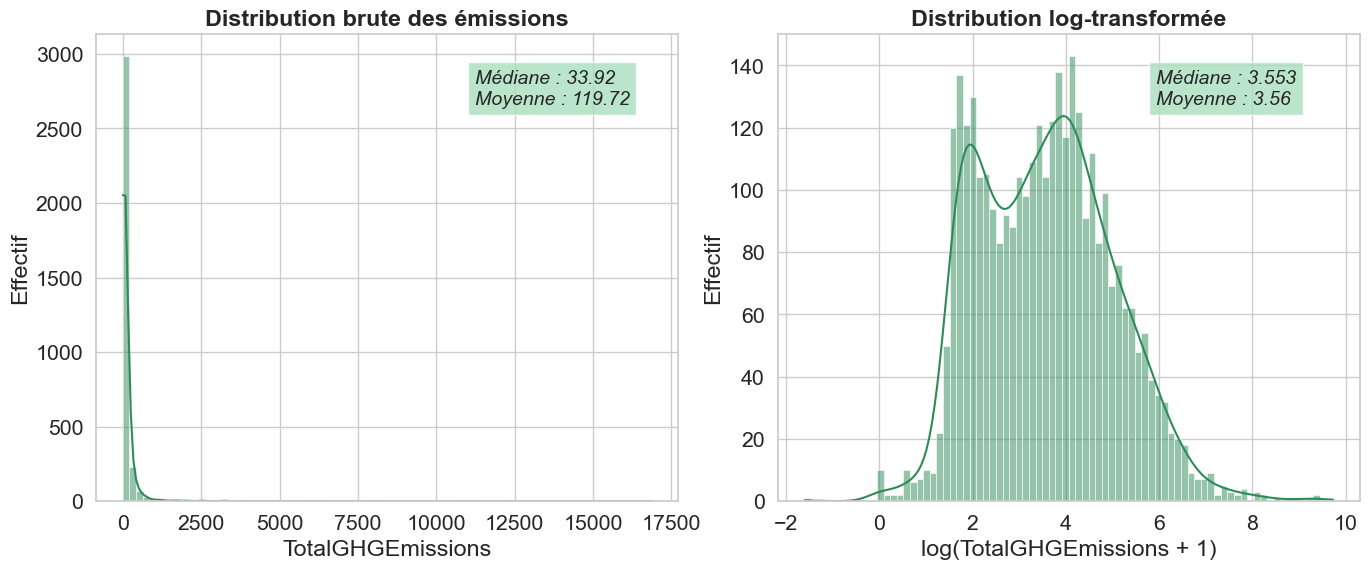

In [219]:
# Histogrammes comparatifs : variable brute vs log-transformée
main_color = "#2E8B57"   # SeaGreen
box_color  = "#A9DFBF"   # Light green


sns.set(
    style="whitegrid",
    rc={"figure.figsize": (14, 6)},
    font_scale=1.4
)

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False)


# 1. Histogramme variable brute

target = df_raw['TotalGHGEmissions'].dropna()

ax1 = sns.histplot(
    target,
    bins=80,
    kde=True,
    color=main_color,
    ax=axes[0]
)

ax1.text(
    0.65, 0.85,
    f"Médiane : {target.median():.2f}\n"
    f"Moyenne : {target.mean():.2f}",
    transform=ax1.transAxes,
    fontsize=14,
    style='italic',
    bbox=dict(facecolor=box_color, alpha=0.8, pad=5)
)

ax1.set_title("Distribution brute des émissions", fontweight="bold")
ax1.set_xlabel("TotalGHGEmissions")
ax1.set_ylabel("Effectif")


# Histogramme log-transformé

log_target = np.log1p(target)

ax2 = sns.histplot(
    log_target,
    bins=80,
    kde=True,
    color=main_color,
    ax=axes[1]
)

ax2.text(
    0.65, 0.85,
    f"Médiane : {log_target.median():.3f}\n"
    f"Moyenne : {log_target.mean():.2f}",
    transform=ax2.transAxes,
    fontsize=14,
    style='italic',
    bbox=dict(facecolor=box_color, alpha=0.8, pad=5)
)

ax2.set_title("Distribution log-transformée", fontweight="bold")
ax2.set_xlabel("log(TotalGHGEmissions + 1)")
ax2.set_ylabel("Effectif")


plt.tight_layout()
plt.show()


In [220]:
# Test de normalité pour la variable log-transformée
print('\nTests sur variable log-transformée')
print('----'*10)

log_std = (log_target - log_target.mean()) / log_target.std()

# Normaltest
stat, p = normaltest(log_target)
print(f"Agostino-Pearson: p = {p:.3e} -> {interpret_test(p)}")

# Shapiro
if len(log_target) < 5000:
    stat, p = shapiro(log_target)
    print(f"Shapiro: p = {p:.3e} -> {interpret_test(p)}")

# KS
stat, p = kstest(log_std, 'norm')
print(f"Kolmogorov–Smirnov: p = {p:.3e} -> {interpret_test(p)}")


# Jarque-Bera
stat, p = jarque_bera(log_target)
print(f"Jarque-Bera: p = {p:.3e} -> {interpret_test(p)}")



Tests sur variable log-transformée
----------------------------------------
Agostino-Pearson: p = 7.249e-14 -> Distribution non normale (H0 rejetée)
Shapiro: p = 6.732e-19 -> Distribution non normale (H0 rejetée)
Kolmogorov–Smirnov: p = 9.563e-09 -> Distribution non normale (H0 rejetée)
Jarque-Bera: p = 1.641e-14 -> Distribution non normale (H0 rejetée)


La transformation log ne donne pas une distribution normale mais semble un peu plus s'apporcher de la loi normale que la distribution de la variable cible sans transformation.

### Autres transformations

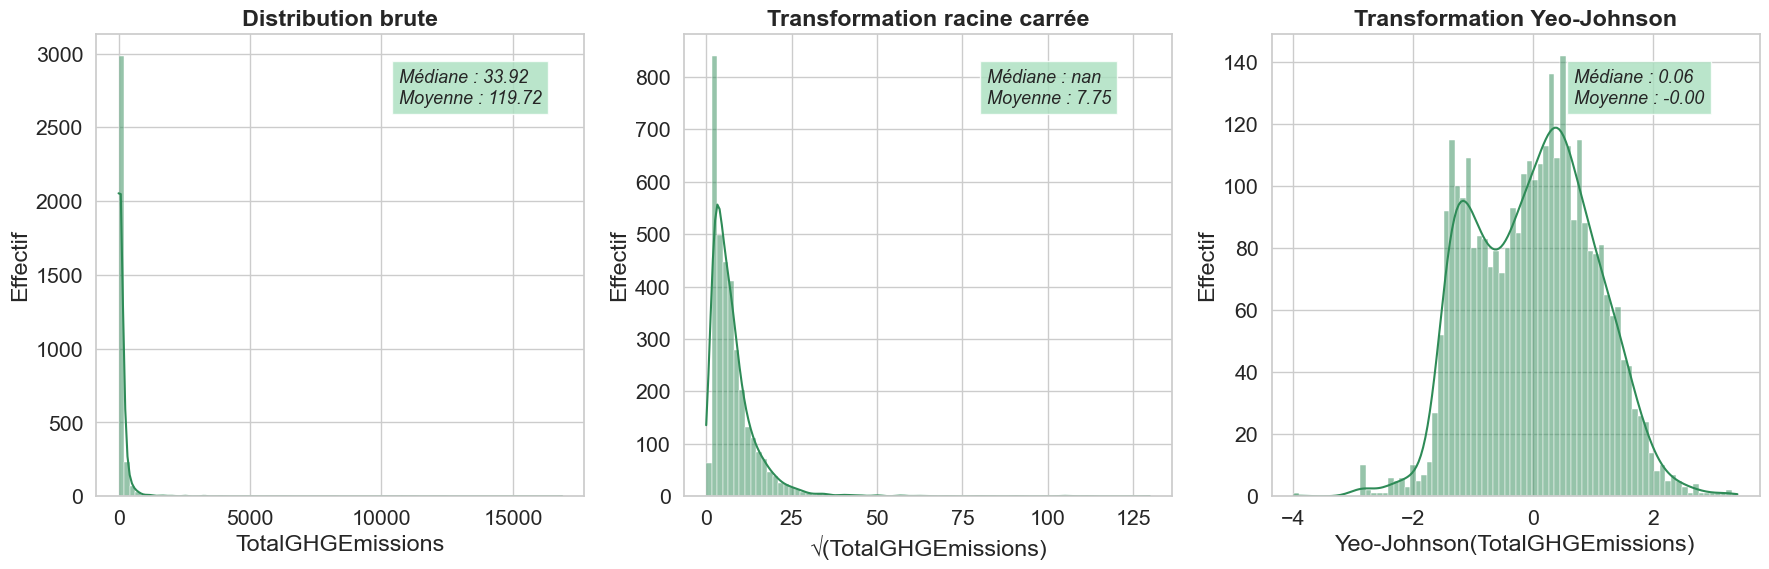

In [221]:
from sklearn.preprocessing import PowerTransformer

#  Couleurs
main_color = "#2E8B57"   # SeaGreen
box_color  = "#A9DFBF"   # Light green

#  Style seaborn
sns.set(
    style="whitegrid",
    rc={"figure.figsize": (18, 6)},
    font_scale=1.4
)

# Variable cible
target = df_raw["TotalGHGEmissions"].dropna()

# Transformations
sqrt_target = np.sqrt(target)

pt = PowerTransformer(method="yeo-johnson")
yj_target = pt.fit_transform(target.values.reshape(-1, 1)).flatten()

#  Figure
fig, axes = plt.subplots(1, 3, sharey=False)

#  Distribution brute
ax1 = sns.histplot(
    target,
    bins=80,
    kde=True,
    color=main_color,
    ax=axes[0]
)

ax1.text(
    0.62, 0.85,
    f"Médiane : {target.median():.2f}\nMoyenne : {target.mean():.2f}",
    transform=ax1.transAxes,
    fontsize=13,
    style="italic",
    bbox=dict(facecolor=box_color, alpha=0.8, pad=5)
)

ax1.set_title("Distribution brute", fontweight="bold")
ax1.set_xlabel("TotalGHGEmissions")
ax1.set_ylabel("Effectif")


#  Transformation racine carrée
ax2 = sns.histplot(
    sqrt_target,
    bins=80,
    kde=True,
    color=main_color,
    ax=axes[1]
)

ax2.text(
    0.62, 0.85,
    f"Médiane : {np.median(sqrt_target):.2f}\nMoyenne : {np.mean(sqrt_target):.2f}",
    transform=ax2.transAxes,
    fontsize=13,
    style="italic",
    bbox=dict(facecolor=box_color, alpha=0.8, pad=5)
)

ax2.set_title("Transformation racine carrée", fontweight="bold")
ax2.set_xlabel("√(TotalGHGEmissions)")
ax2.set_ylabel("Effectif")


#  Transformation Yeo-Johnson (fonctionne avec valeurs négatives)
ax3 = sns.histplot(
    yj_target,
    bins=80,
    kde=True,
    color=main_color,
    ax=axes[2]
)

ax3.text(
    0.62, 0.85,
    f"Médiane : {np.median(yj_target):.2f}\nMoyenne : {np.mean(yj_target):.2f}",
    transform=ax3.transAxes,
    fontsize=13,
    style="italic",
    bbox=dict(facecolor=box_color, alpha=0.8, pad=5)
)

ax3.set_title("Transformation Yeo-Johnson", fontweight="bold")
ax3.set_xlabel("Yeo-Johnson(TotalGHGEmissions)")
ax3.set_ylabel("Effectif")

plt.tight_layout()
plt.show()

Aucune des transformations testées ne permet d’obtenir une distribution parfaitement normale. Néanmoins, la transformation logarithmique conduit à une distribution sensiblement plus symétrique et plus proche de la normalité. Elle sera donc retenue pour la suite de l’analyse.

# Section 3 : Analyse descriptive des variables quantitatives

### Objectifs principaux
1. **Explorer** les variables quantitatives pertinentes individuellement.
2. **Analyser** les distributions statistiques (histogrammes, boxplots, statistiques descriptives).
3. **Préparer** une synthèse des transformations à prévoir pour le ML (normalisation, scaling).

### Dépendances critiques
* `pandas`, `numpy` : Manipulation et analyse de données.
* `matplotlib`, `seaborn` : Visualisations graphiques.

### Livrables
1. **Tableau des statistiques descriptives** : moyenne, médiane, écart-type, min/max.
2. **Graphiques de distribution** : histogrammes et boxplots pour chaque variable numérique.
3. **Rapport de synthèse** : observations sur les outliers et recommandations pour la préparation des données.

In [177]:

# Sélection des variables numériques
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()

# Affichage du résultat
numeric_cols

['OSEBuildingID',
 'DataYear',
 'ZipCode',
 'CouncilDistrictCode',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'Comments',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity']

In [179]:
print(f"Nombre de variables quantitatives : {len(numeric_cols)}")

Nombre de variables quantitatives : 30



=== YearBuilt ===
count: 3376.00
mean: 1968.57
median: 1975.00
min: 1900.00
max: 2015.00
std: 33.09
variance: 1094.83
skewness: -0.54
kurtosis: -0.87


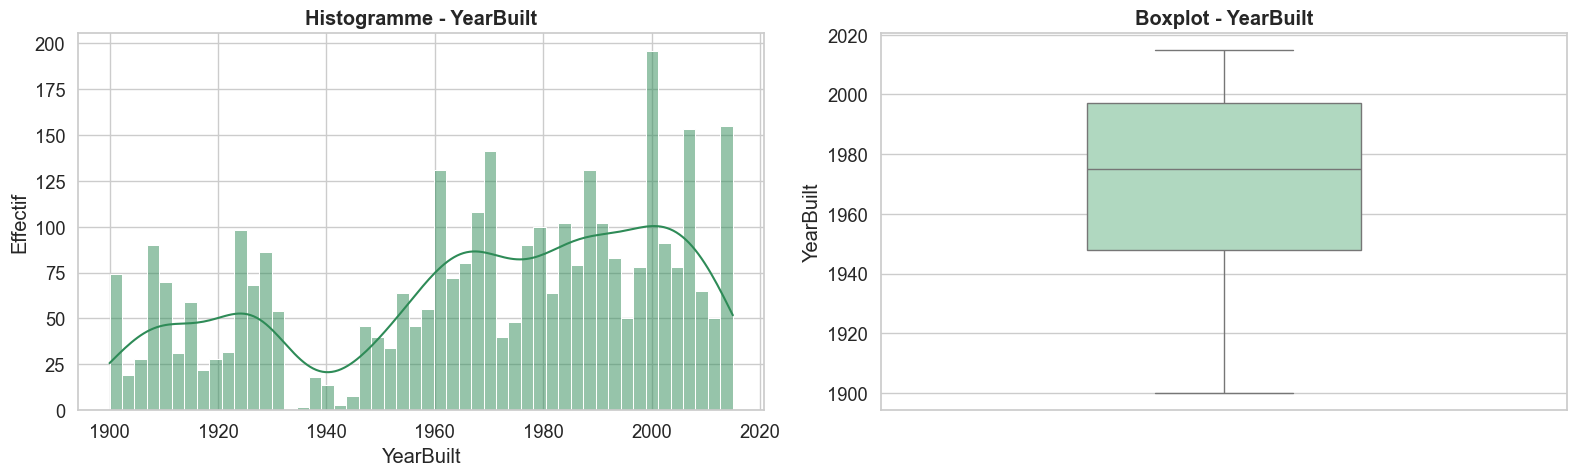


=== NumberofBuildings ===
count: 3368.00
mean: 1.11
median: 1.00
min: 0.00
max: 111.00
std: 2.11
variance: 4.45
skewness: 43.39
kurtosis: 2205.30


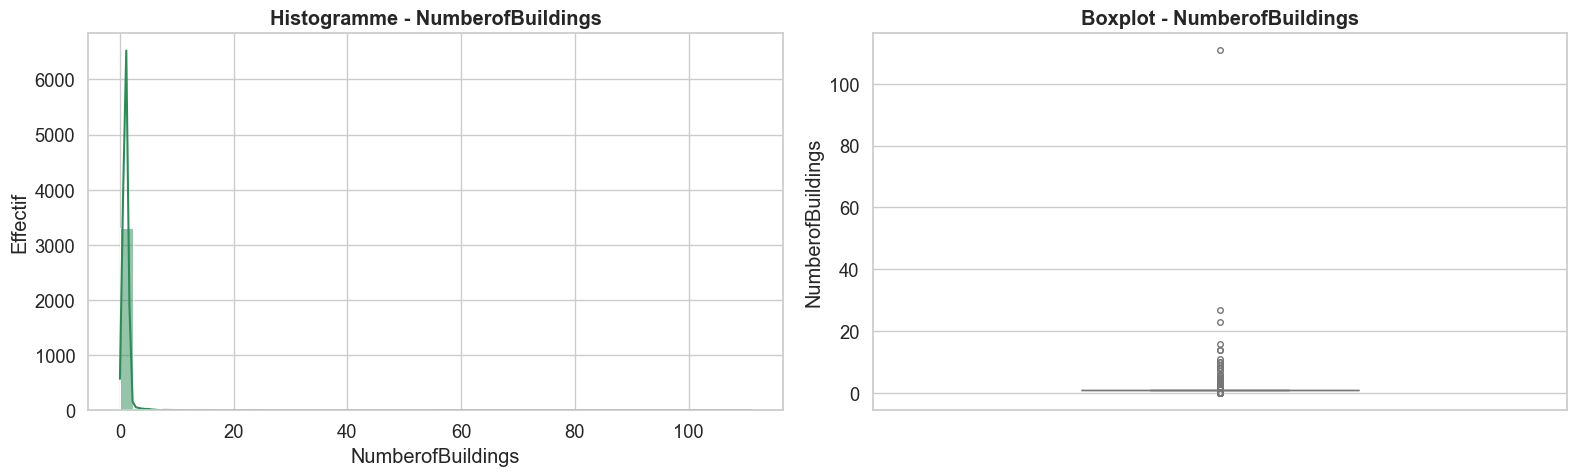


=== NumberofFloors ===
count: 3376.00
mean: 4.71
median: 4.00
min: 0.00
max: 99.00
std: 5.49
variance: 30.19
skewness: 5.92
kurtosis: 55.95


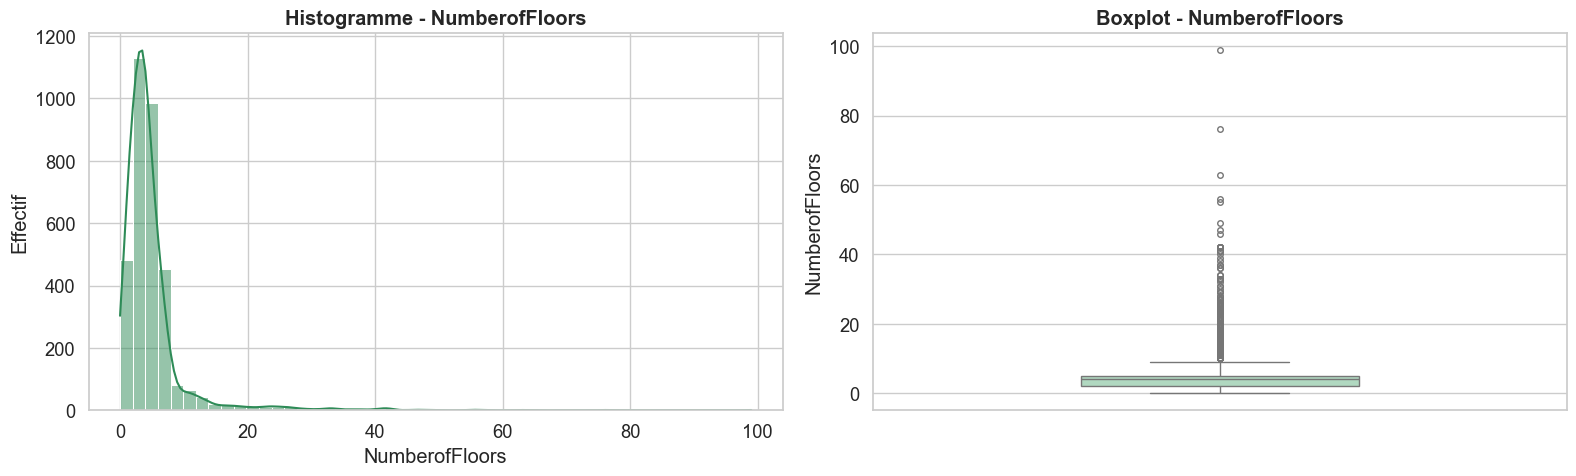


=== PropertyGFATotal ===
count: 3376.00
mean: 94833.54
median: 44175.00
min: 11285.00
max: 9320156.00
std: 218837.61
variance: 47889898290.17
skewness: 24.13
kurtosis: 946.24


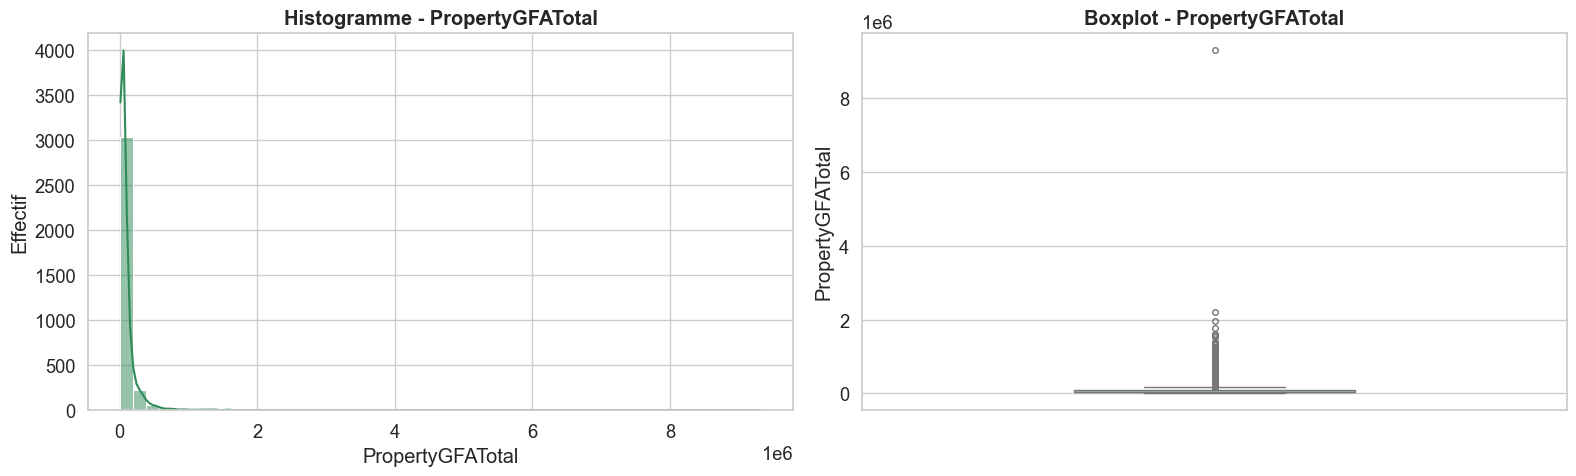


=== PropertyGFAParking ===
count: 3376.00
mean: 8001.53
median: 0.00
min: 0.00
max: 512608.00
std: 32326.72
variance: 1045017079.95
skewness: 6.65
kurtosis: 58.97


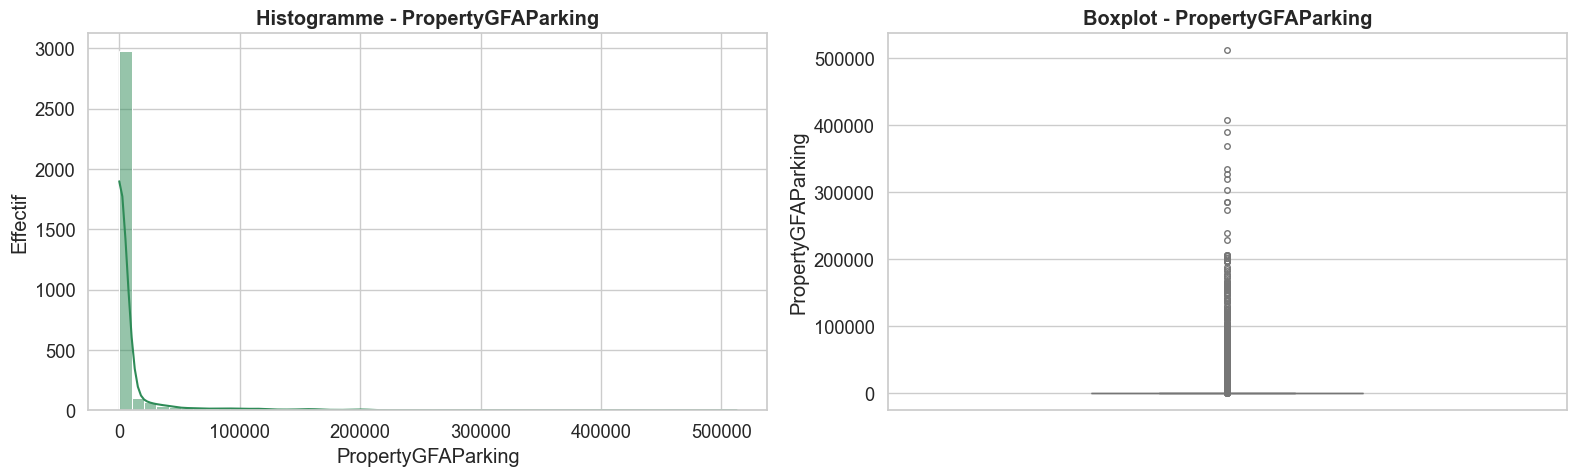


=== PropertyGFABuilding(s) ===
count: 3376.00
mean: 86832.01
median: 43216.00
min: 3636.00
max: 9320156.00
std: 207939.81
variance: 43238965382.50
skewness: 27.62
kurtosis: 1161.36


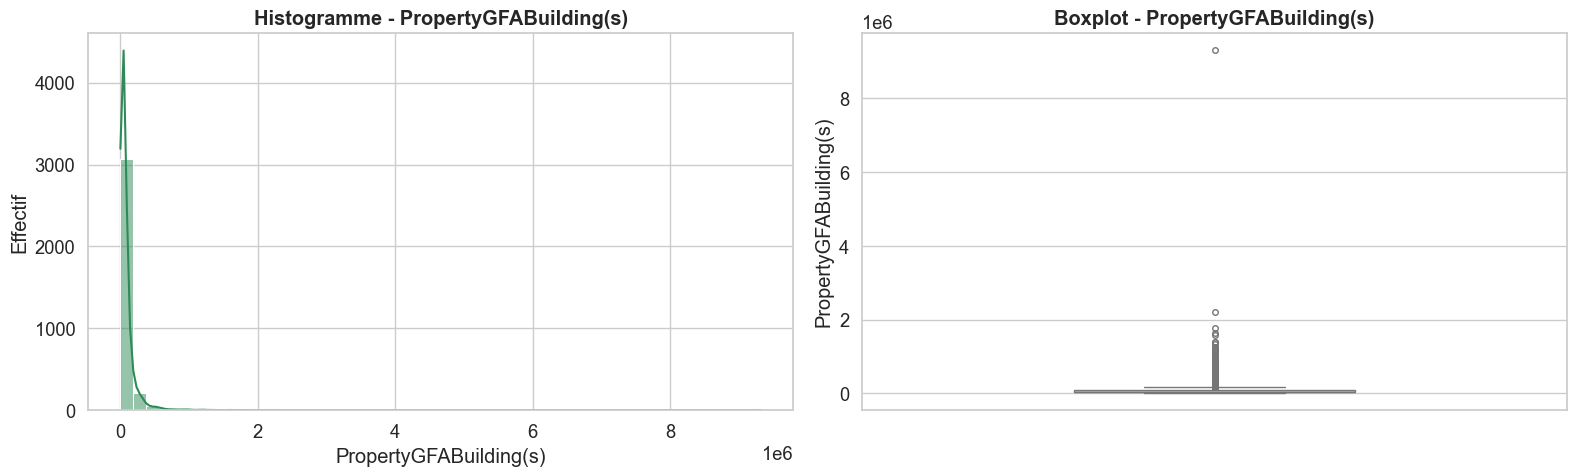


=== ENERGYSTARScore ===
count: 2533.00
mean: 67.92
median: 75.00
min: 1.00
max: 100.00
std: 26.87
variance: 722.17
skewness: -0.86
kurtosis: -0.22


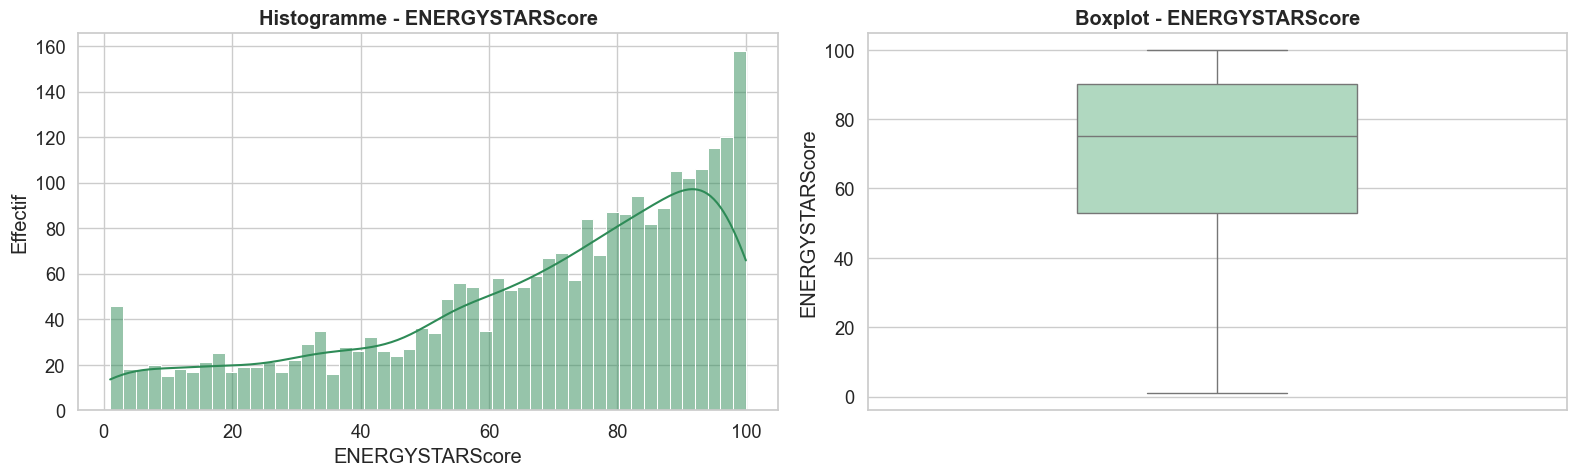


=== SiteEUI(kBtu/sf) ===
count: 3369.00
mean: 54.73
median: 38.60
min: 0.00
max: 834.40
std: 56.27
variance: 3166.66
skewness: 4.98
kurtosis: 39.99


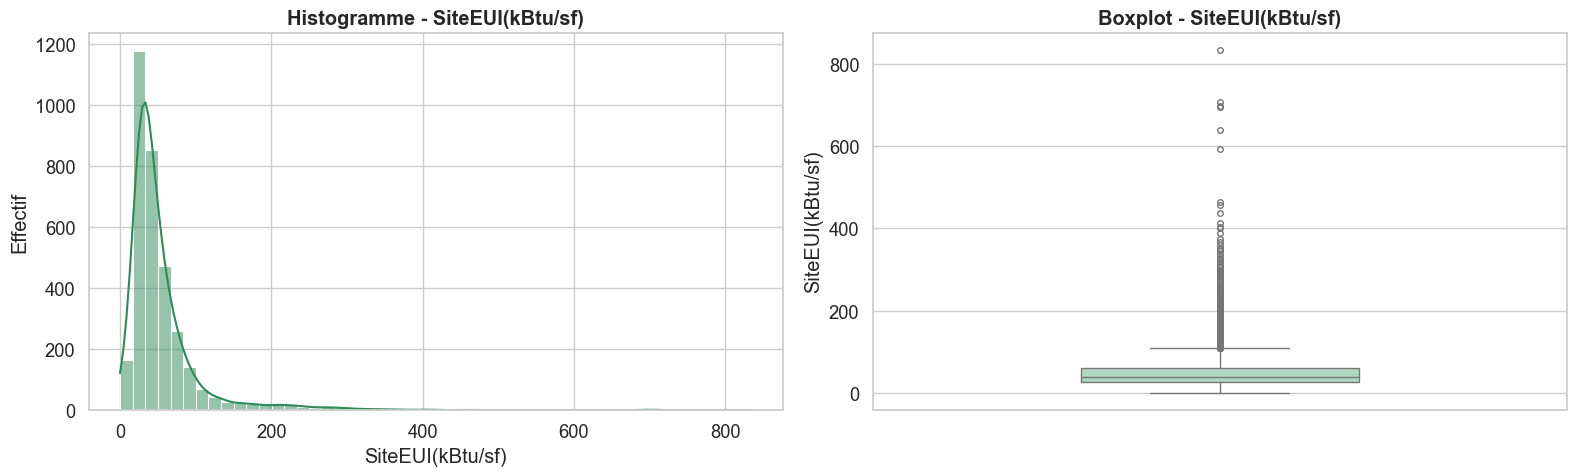


=== SiteEUIWN(kBtu/sf) ===
count: 3370.00
mean: 57.03
median: 40.90
min: 0.00
max: 834.40
std: 57.16
variance: 3267.65
skewness: 4.83
kurtosis: 37.64


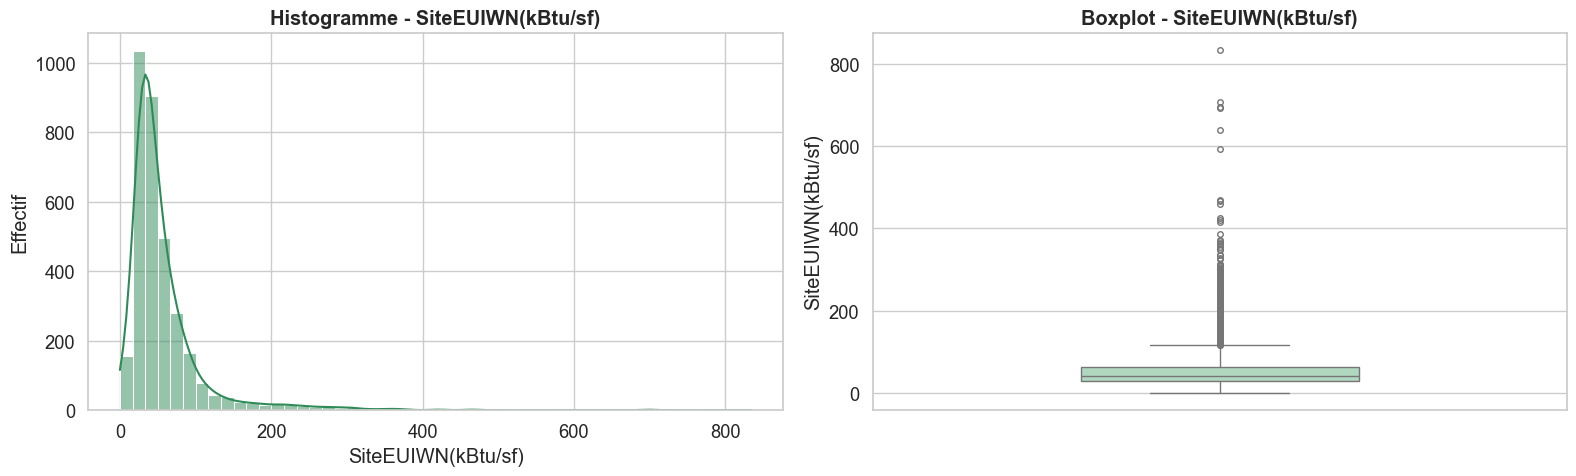


=== SourceEUI(kBtu/sf) ===
count: 3367.00
mean: 134.23
median: 96.20
min: 0.00
max: 2620.00
std: 139.29
variance: 19401.02
skewness: 6.60
kurtosis: 77.66


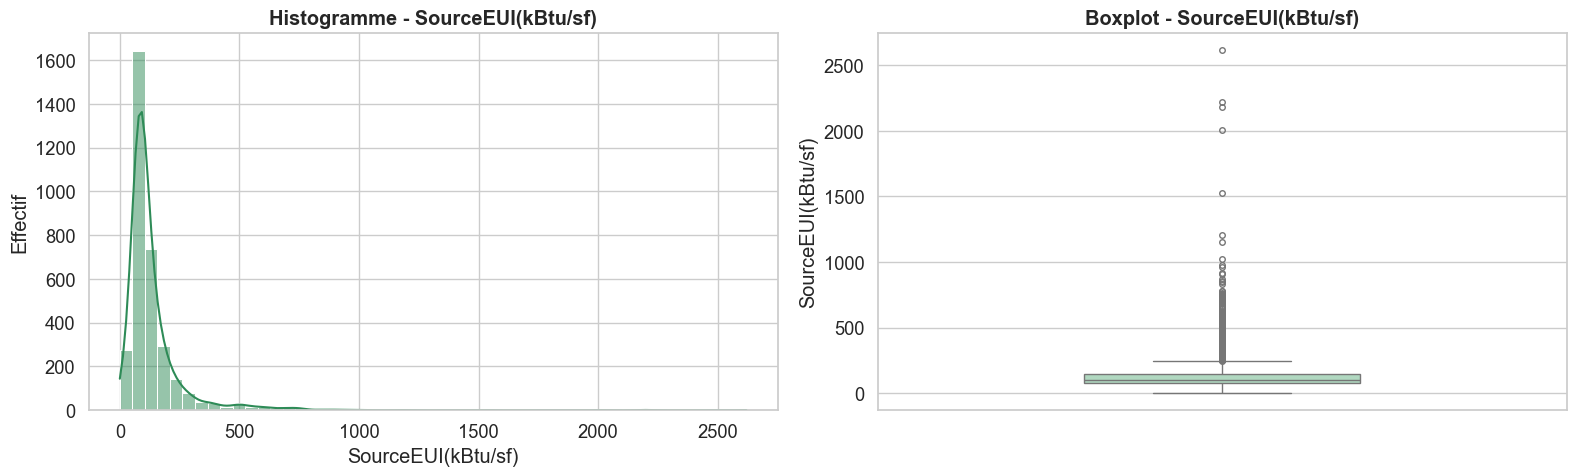


=== SourceEUIWN(kBtu/sf) ===
count: 3367.00
mean: 137.78
median: 101.10
min: -2.10
max: 2620.00
std: 139.11
variance: 19351.54
skewness: 6.57
kurtosis: 77.44


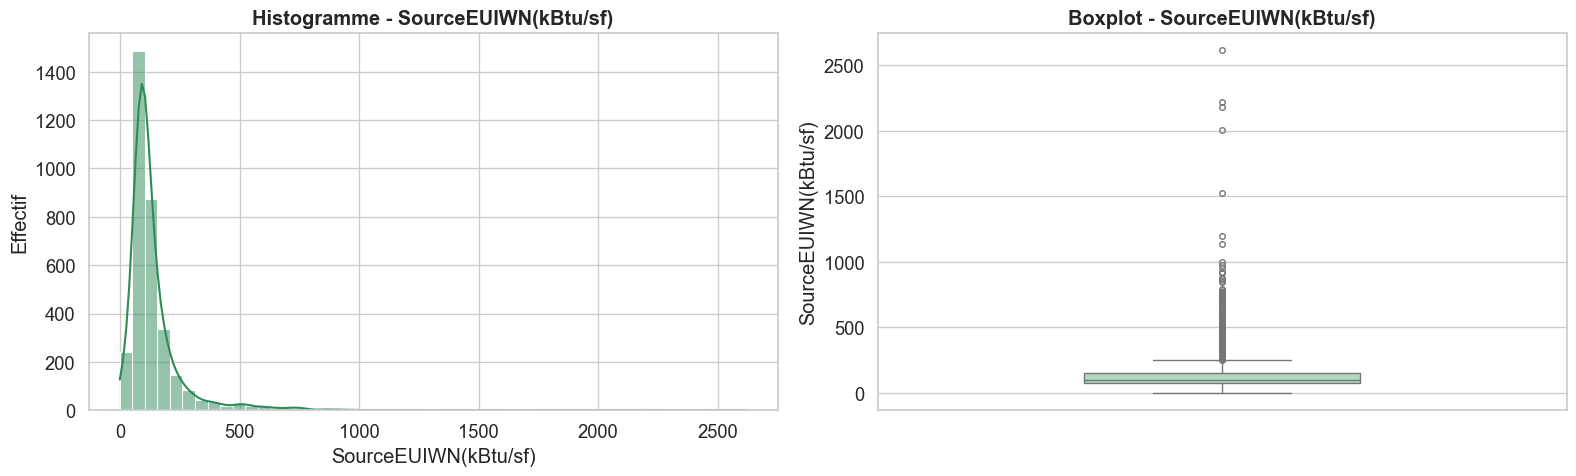


=== SiteEnergyUse(kBtu) ===
count: 3371.00
mean: 5403667.29
median: 1803753.25
min: 0.00
max: 873923712.00
std: 21610628.63
variance: 467019269681710.81
skewness: 24.84
kurtosis: 858.62


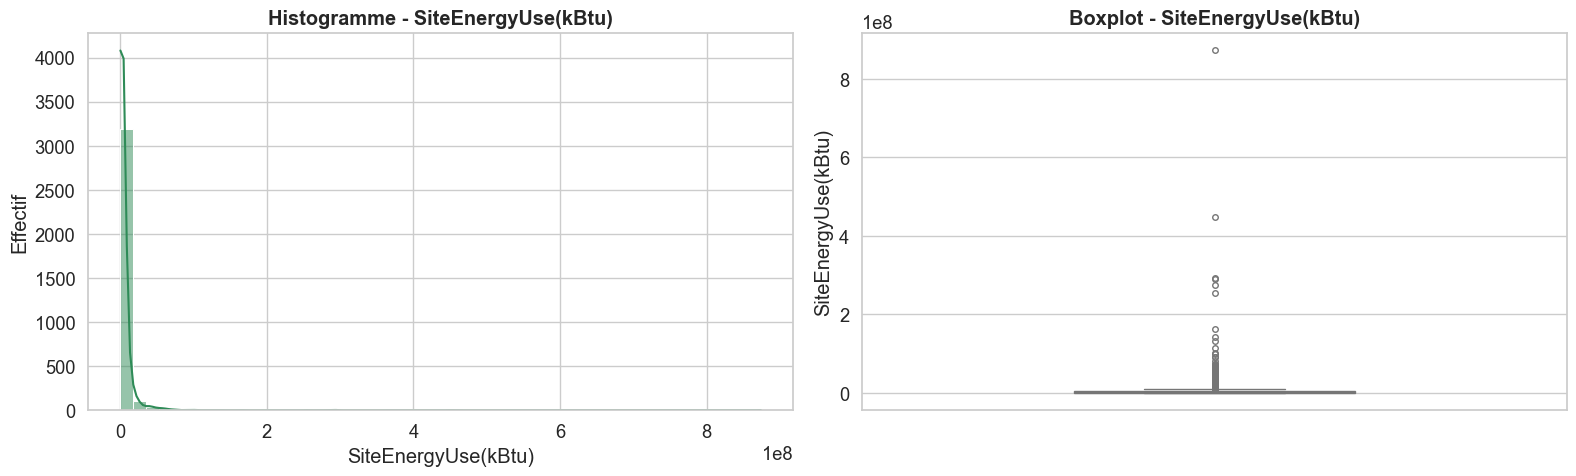


=== SiteEnergyUseWN(kBtu) ===
count: 3370.00
mean: 5276725.71
median: 1904452.00
min: 0.00
max: 471613856.00
std: 15938786.48
variance: 254044914586412.72
skewness: 15.27
kurtosis: 334.51


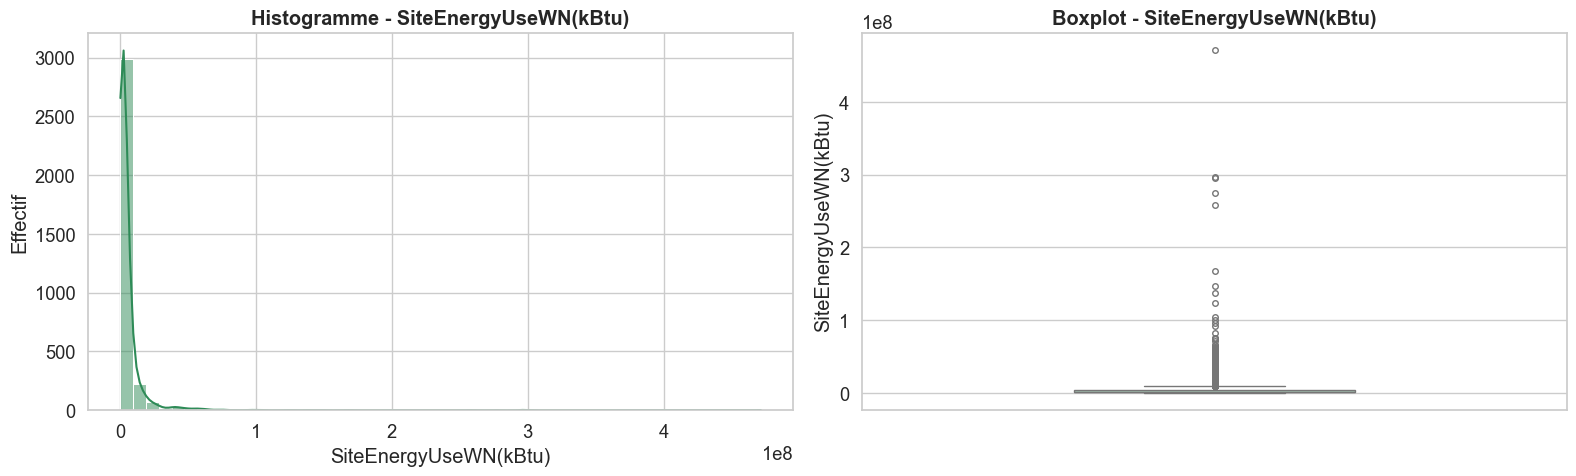


=== SteamUse(kBtu) ===
count: 3367.00
mean: 274595.90
median: 0.00
min: 0.00
max: 134943456.00
std: 3912173.39
variance: 15305100654519.36
skewness: 26.72
kurtosis: 804.86


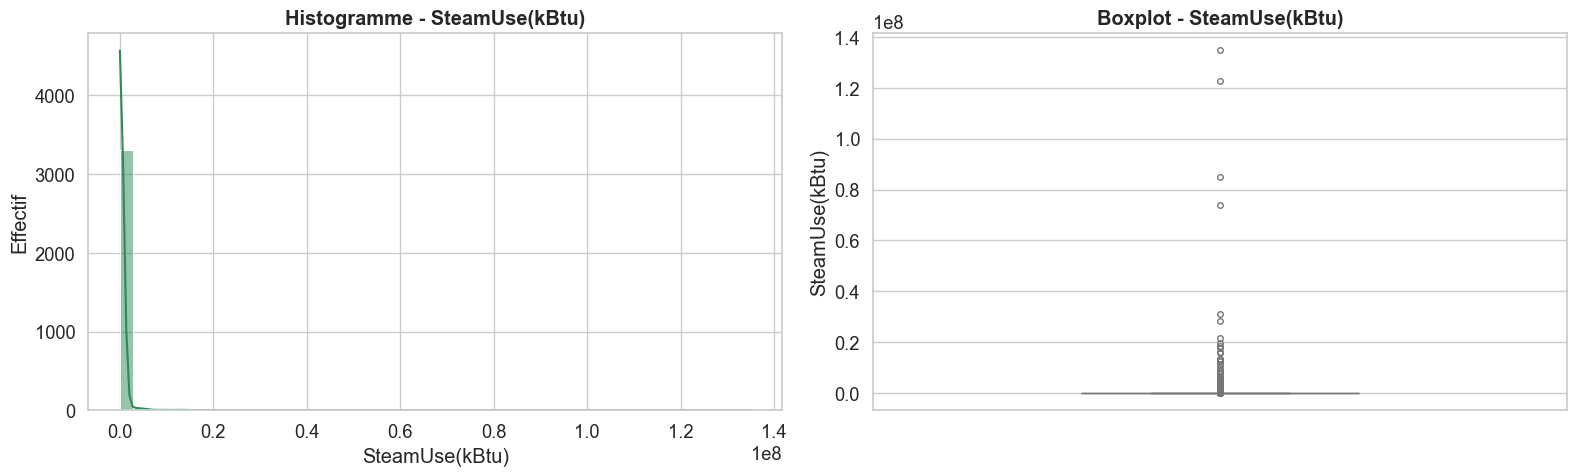


=== Electricity(kWh) ===
count: 3367.00
mean: 1086638.97
median: 345129.91
min: -33826.80
max: 192577488.00
std: 4352478.36
variance: 18944067832564.91
skewness: 28.73
kurtosis: 1157.50


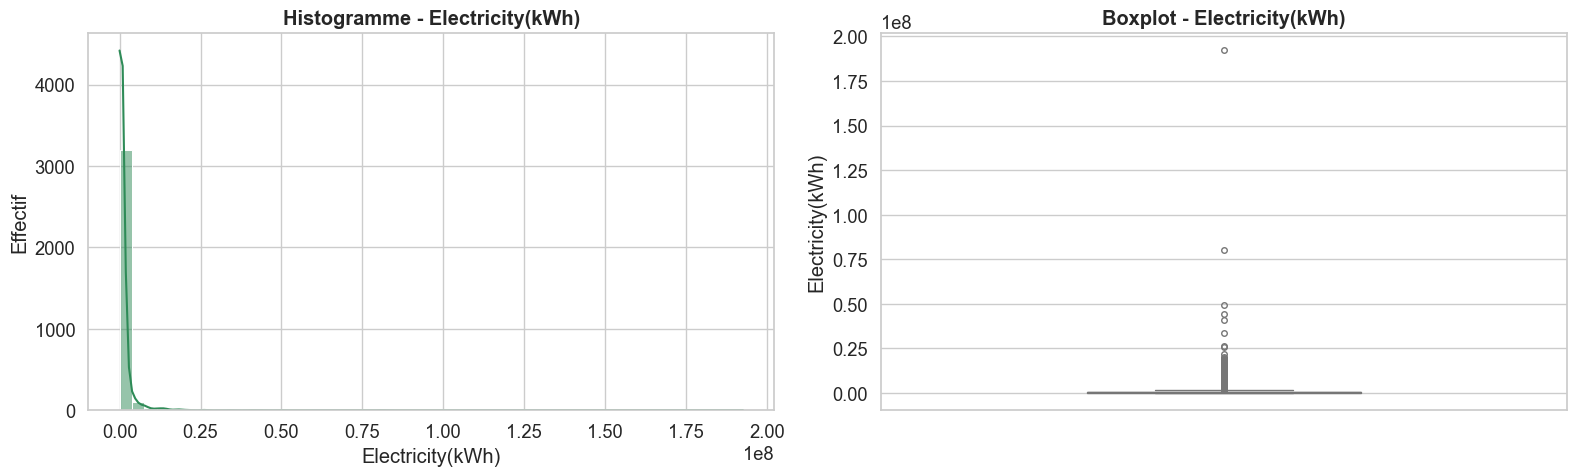


=== Electricity(kBtu) ===
count: 3367.00
mean: 3707612.16
median: 1177583.00
min: -115417.00
max: 657074389.00
std: 14850656.14
variance: 220541987757729.38
skewness: 28.73
kurtosis: 1157.50


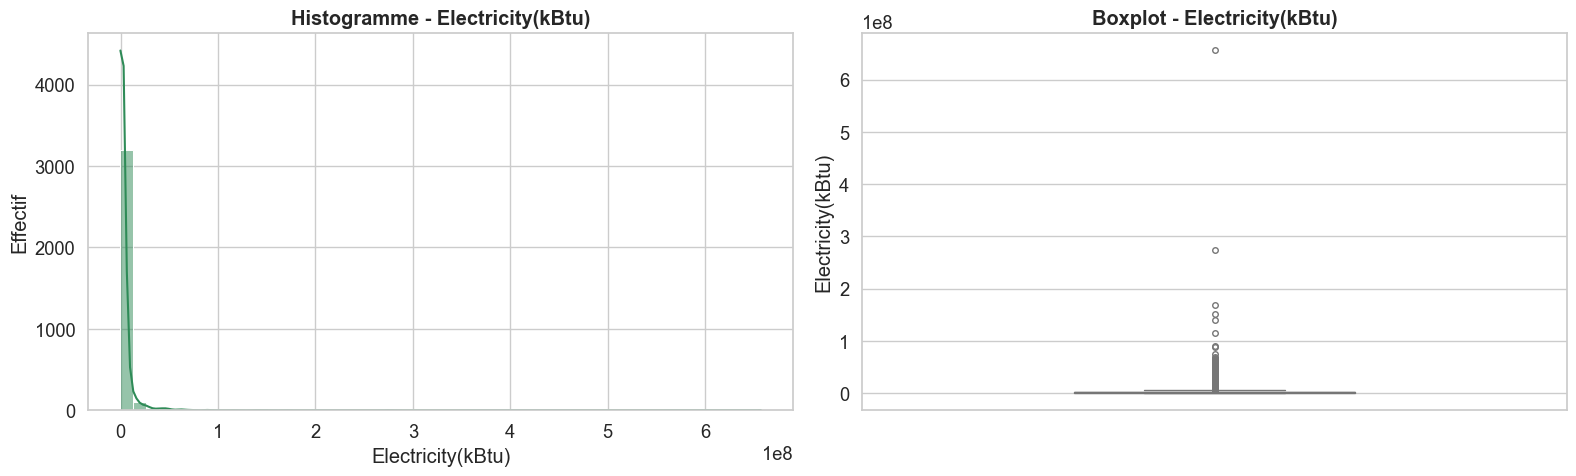


=== NaturalGas(therms) ===
count: 3367.00
mean: 13685.05
median: 3237.54
min: 0.00
max: 2979090.00
std: 67097.81
variance: 4502115878.06
skewness: 30.04
kurtosis: 1201.03


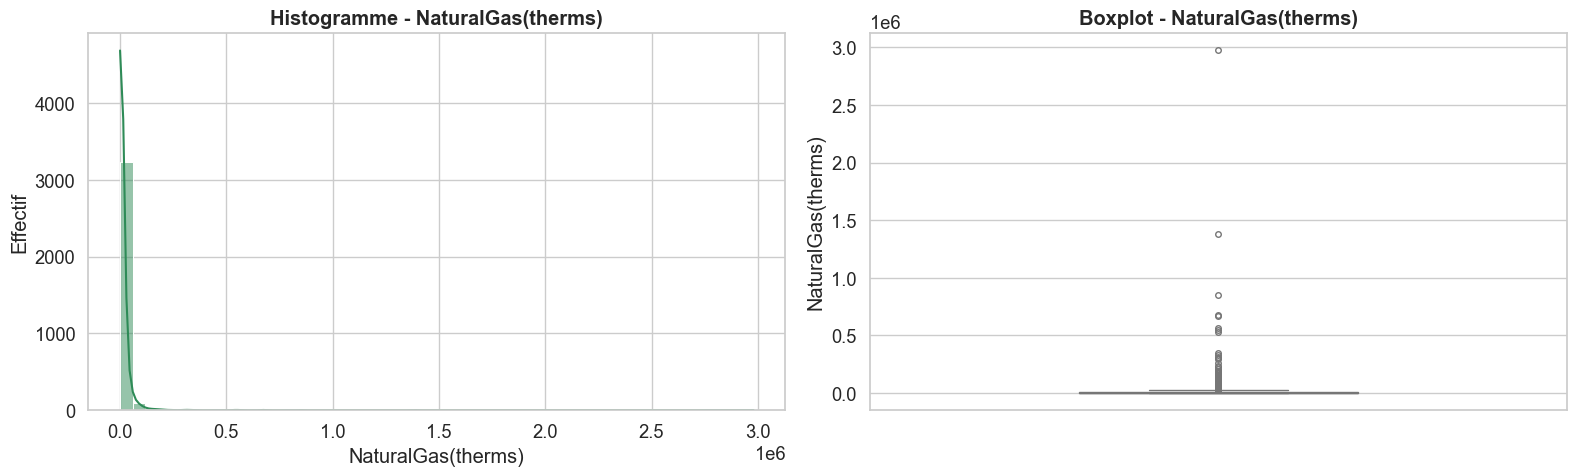


=== NaturalGas(kBtu) ===
count: 3367.00
mean: 1368504.54
median: 323754.00
min: 0.00
max: 297909000.00
std: 6709780.83
variance: 45021158852124.20
skewness: 30.04
kurtosis: 1201.03


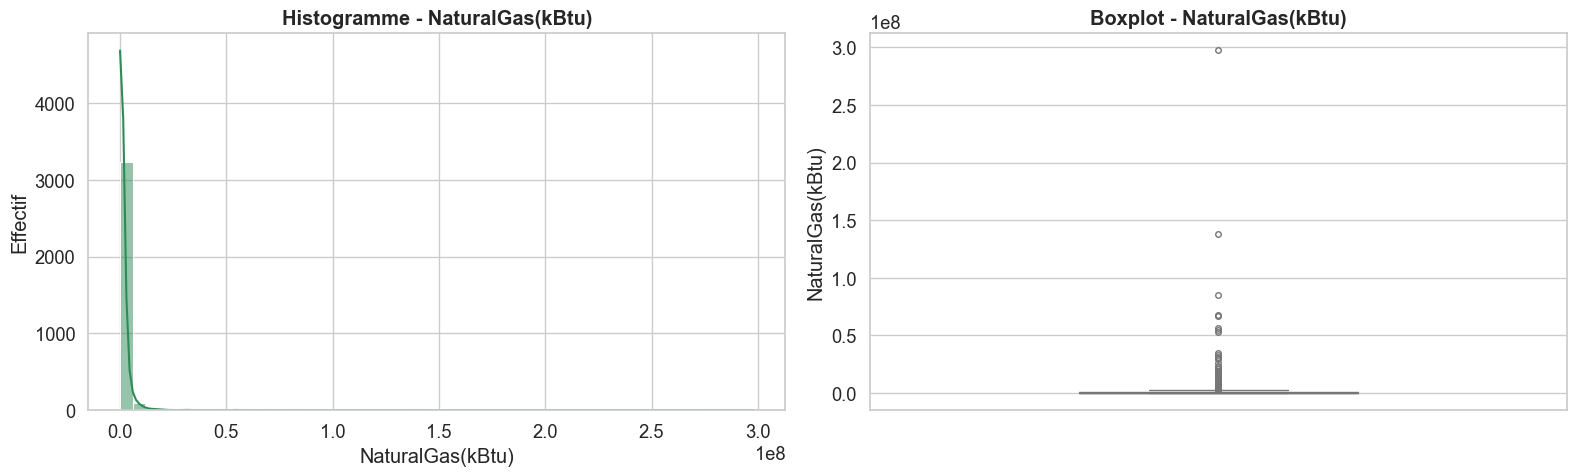


=== GHGEmissionsIntensity ===
count: 3367.00
mean: 1.18
median: 0.61
min: -0.02
max: 34.09
std: 1.82
variance: 3.32
skewness: 5.59
kurtosis: 57.37


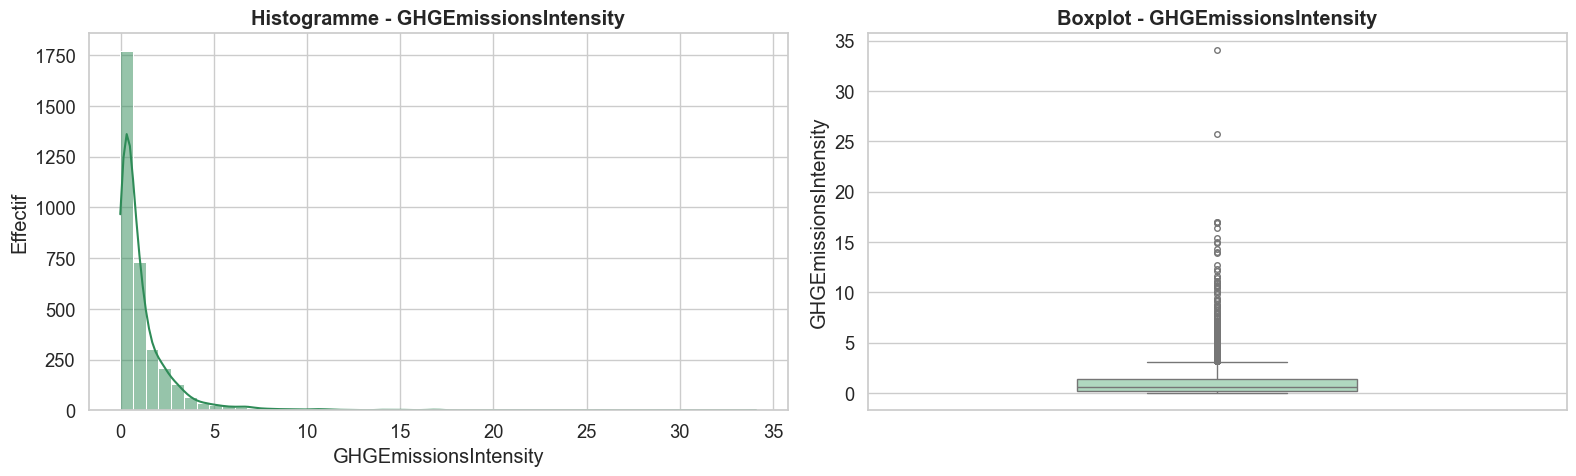

In [224]:
# Couleurs
main_color = "#2E8B57"   # SeaGreen
box_color = "#A9DFBF"    # Light green

# Variables quantitatives importantes
numeric_vars = [
    'YearBuilt',
    'NumberofBuildings',
    'NumberofFloors',
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'ENERGYSTARScore',
    'SiteEUI(kBtu/sf)',
    'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)',
    'SiteEnergyUse(kBtu)',
    'SiteEnergyUseWN(kBtu)',
    'SteamUse(kBtu)',
    'Electricity(kWh)',
    'Electricity(kBtu)',
    'NaturalGas(therms)',
    'NaturalGas(kBtu)',
    'GHGEmissionsIntensity'
]

# Paramètres généraux
sns.set(style="whitegrid", font_scale=1.2)
pd.set_option('display.float_format', '{:.2f}'.format)

# Boucle sur toutes les variables numériques
for col in numeric_vars:
    data = df_raw[col].dropna()
    
    # Calcul statistiques
    stats = {
        'count': data.count(),
        'mean': data.mean(),
        'median': data.median(),
        'min': data.min(),
        'max': data.max(),
        'std': data.std(),
        'variance': data.var(),
        'skewness': data.skew(),
        'kurtosis': data.kurtosis()
    }
    
    # Affichage des stats
    print(f"\n=== {col} ===")
    for k, v in stats.items():
        print(f"{k}: {v:.2f}")
    
    # Création figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Histogramme
    sns.histplot(data, bins=50, kde=True, color=main_color, ax=axes[0])
    axes[0].set_title(f"Histogramme - {col}", fontweight='bold')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Effectif")
    
    # Boxplot
    sns.boxplot(y=data, color=box_color, width=0.4, fliersize=4, ax=axes[1])
    axes[1].set_title(f"Boxplot - {col}", fontweight='bold')
    axes[1].set_ylabel(col)
    
    plt.tight_layout()
    plt.show()


### Focus sur ENERGYSTARScore

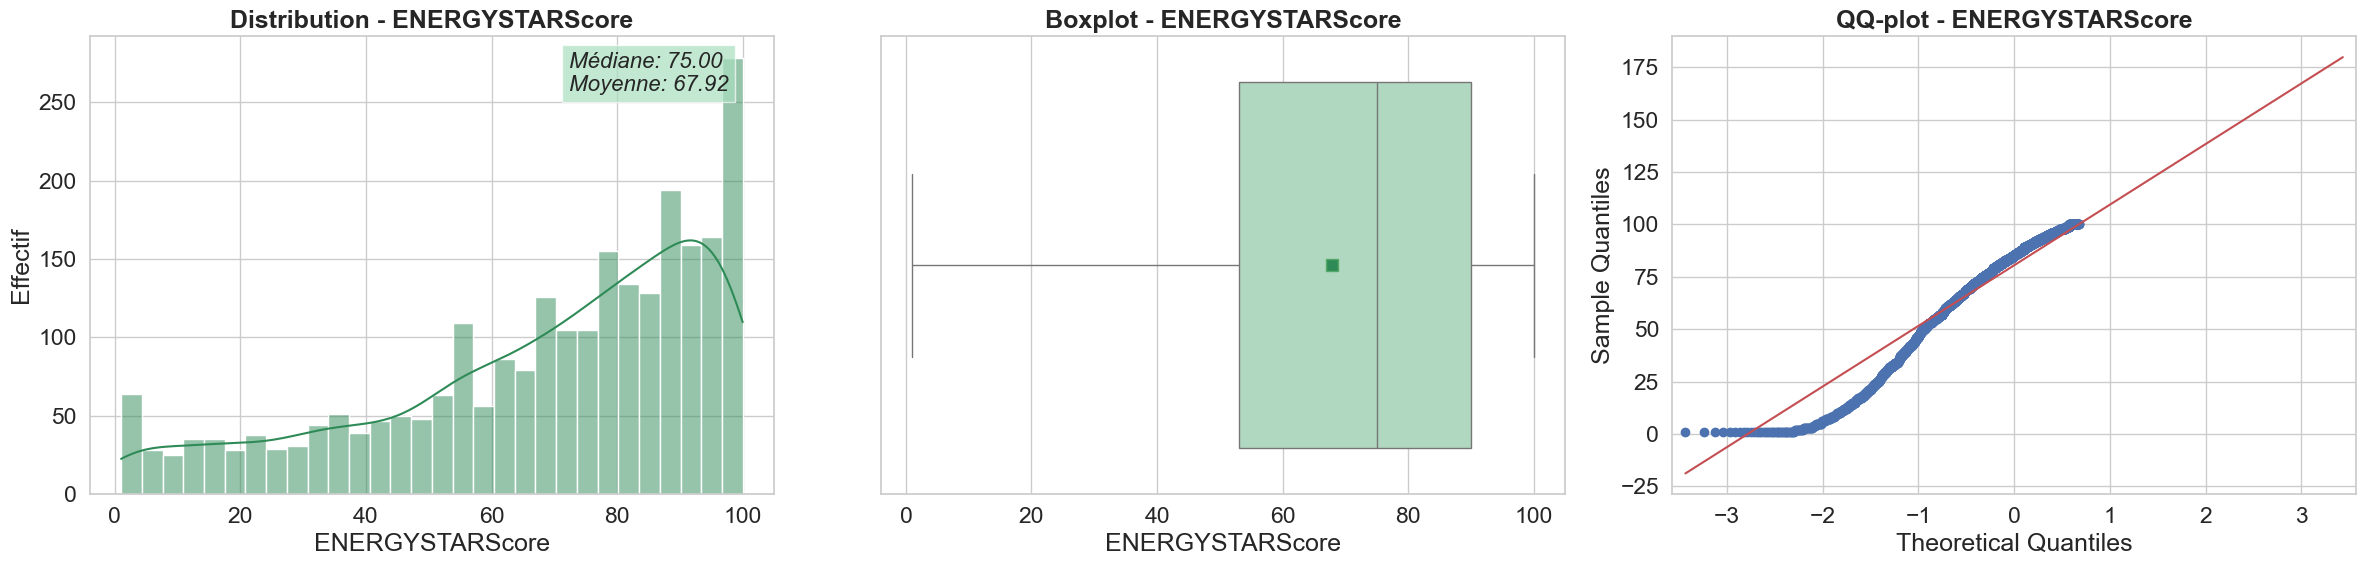

In [184]:
# Couleurs
main_color = "#2E8B57"   # SeaGreen
box_color = "#A9DFBF"    # Light green

sns.set(
    rc={'figure.figsize': (24, 6)},
    font_scale=1.5,
    style="whitegrid"
)

fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False)

# ----- Histogramme -----
ax = sns.histplot(
    data=df_raw,
    x='ENERGYSTARScore',
    kde=True,
    ax=axes[0],
    bins=30,
    color=main_color
)
ax.text(
    0.7, 0.88,
    f"Médiane: {df_raw['ENERGYSTARScore'].median():.2f}\n"
    f"Moyenne: {df_raw['ENERGYSTARScore'].mean():.2f}",
    style='italic',
    transform=ax.transAxes,
    fontsize=16,
    bbox={'facecolor': box_color, 'alpha':0.7, 'pad':5}
)
ax.set_title("Distribution - ENERGYSTARScore", fontweight="bold")
ax.set_xlabel("ENERGYSTARScore")
ax.set_ylabel("Effectif")

# ----- Boxplot -----
sns.boxplot(
    data=df_raw,
    x='ENERGYSTARScore',
    ax=axes[1],
    color=box_color,
    showmeans=True,
    meanprops={
        "marker": "s",
        "markerfacecolor": main_color,
        "markersize": 8
    }
)
axes[1].set_title("Boxplot - ENERGYSTARScore", fontweight="bold")
axes[1].set_xlabel("ENERGYSTARScore")

# ----- QQ-plot -----
sm.qqplot(df_raw['ENERGYSTARScore'], line="q", ax=axes[2], color=main_color)
axes[2].set_title("QQ-plot - ENERGYSTARScore", fontweight="bold")

plt.tight_layout()
plt.show()

In [187]:
# normality test (normaltest)

target_0 = df_raw['ENERGYSTARScore'].dropna()

alpha = 0.05


# Fonction d'interprétation

def interpret_test(p_value, alpha=0.05):
    return "Distribution compatible avec la normalité (H0 non rejetée)" \
        if p_value > alpha else "Distribution non normale (H0 rejetée)"


# D’Agostino-Pearson (normaltest)
print("\n" + "=" * 60)
stat, p = normaltest(target)
print("ENERGYSTARScore Agostino-Pearson")
print(f"Statistic = {stat:.3f}, p-value = {p:.3e}")
print(interpret_test(p))
print("=" * 60)


# Shapiro

if len(target) < 5000:
    stat, p = shapiro(target)
    print("ENERGYSTARScore Shapiro")
    print(f"Statistic = {stat:.3f}, p-value = {p:.3e}")
    print(interpret_test(p))
else:
    print("Shapiro non exécuté : échantillon trop grand (>5000)")
print("=" * 60)


# Kolmogorov–Smirnov

# On compare avec la distribution normale standardisée
target_std = (target - target.mean()) / target.std()
stat, p = kstest(target_std, 'norm')
print("ENERGYSTARScore Kolmogorov–Smirnov")
print(f"Statistic = {stat:.3f}, p-value = {p:.3e}")
print(interpret_test(p))
print("=" * 60)


# Jarque-Bera

stat, p = jarque_bera(target)
print("ENERGYSTARScore Jarque-Bera")
print(f"Statistic = {stat:.3f}, p-value = {p:.3e}")
print(interpret_test(p))
print("=" * 60)


ENERGYSTARScore Agostino-Pearson
Statistic = 245.098, p-value = 5.994e-54
Distribution non normale (H0 rejetée)
ENERGYSTARScore Shapiro
Statistic = 0.905, p-value = 4.745e-37
Distribution non normale (H0 rejetée)
ENERGYSTARScore Kolmogorov–Smirnov
Statistic = 0.116, p-value = 2.709e-30
Distribution non normale (H0 rejetée)
ENERGYSTARScore Jarque-Bera
Statistic = 316.652, p-value = 1.737e-69
Distribution non normale (H0 rejetée)


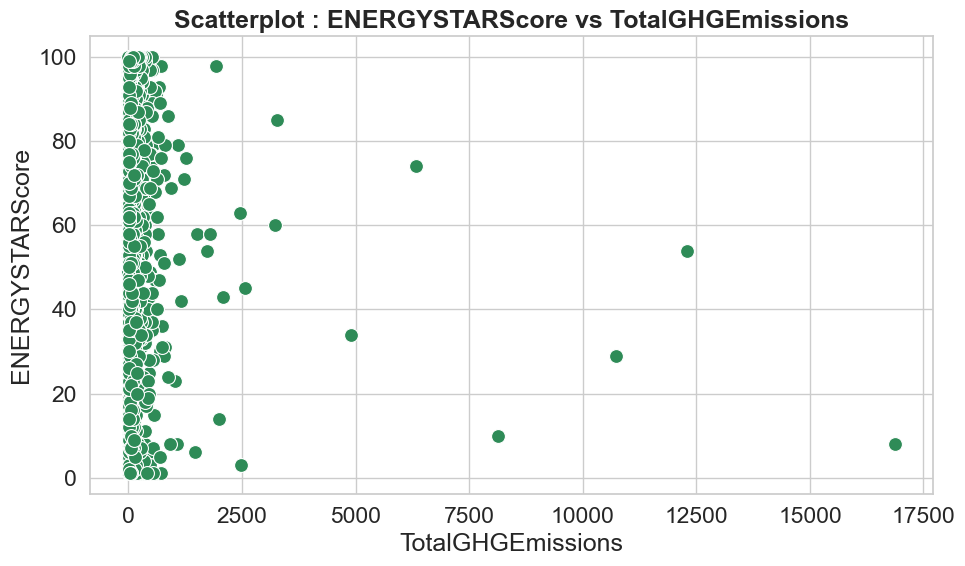

In [193]:
# Couleurs
main_color = "#2E8B57"  # SeaGreen

sns.set(
    rc={'figure.figsize': (10, 6)},
    font_scale=1.5,
    style="whitegrid"
)

fig, ax = plt.subplots(nrows=1, ncols=1)

sns.scatterplot(
    x='TotalGHGEmissions',
    y='ENERGYSTARScore',
    data=df_raw,
    s=100,
    color=main_color,
    ax=ax
)

ax.set_title("Scatterplot : ENERGYSTARScore vs TotalGHGEmissions", fontweight="bold")
ax.set_xlabel("TotalGHGEmissions")
ax.set_ylabel("ENERGYSTARScore")

plt.tight_layout()
plt.show()


### YearBuilt

In [226]:
# Création de la colonne BuildingAge
current_year = 2016  # ou l'année correspondant à tes données
df_raw['BuildingAge'] = current_year - df_raw['YearBuilt']

print(f"Nombre de bâtiments : {df_raw['BuildingAge'].nunique()}")
print(f"Le bâtiment le plus vieux a {df_raw['BuildingAge'].max()} ans.")
print(f"Le bâtiment le plus jeune a {df_raw['BuildingAge'].min()} ans.")

Nombre de bâtiments : 113
Le bâtiment le plus vieux a 116 ans.
Le bâtiment le plus jeune a 1 ans.


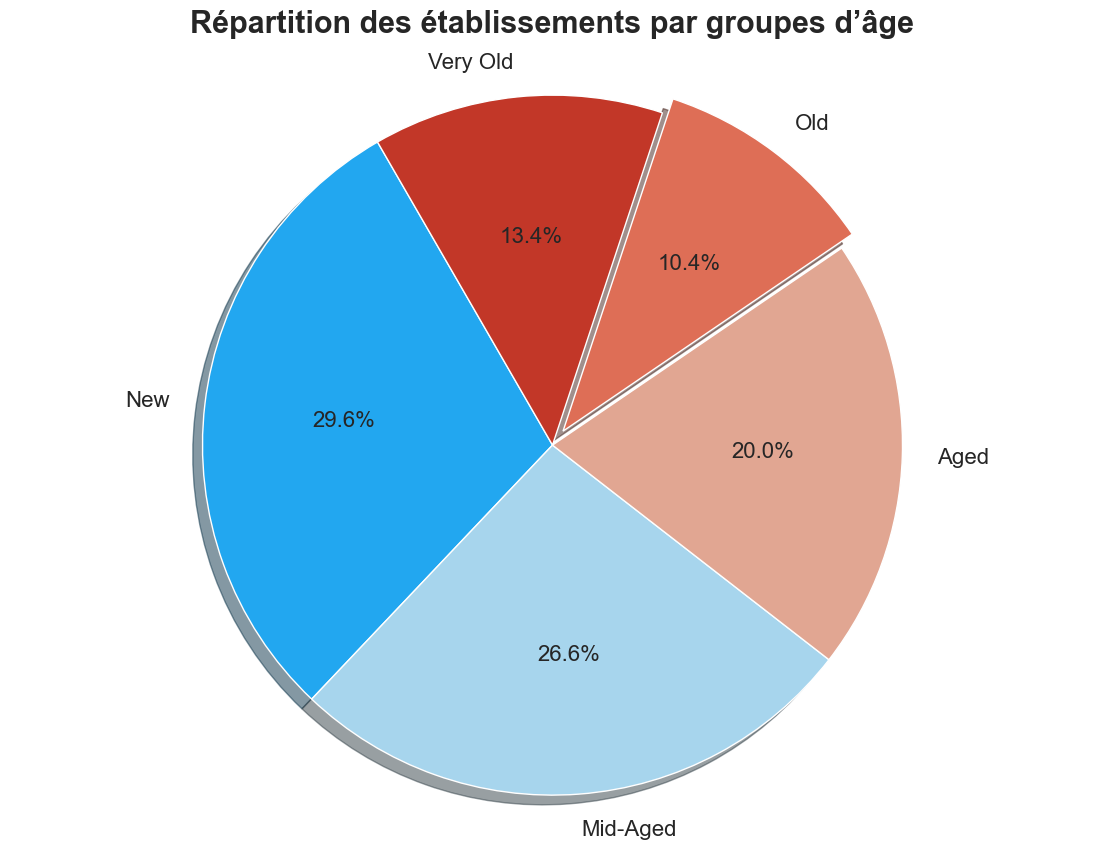

In [229]:

# Création des groupes d’âge

df_raw["AgeGroup"] = pd.cut(
    df_raw["BuildingAge"],
    bins=5,
    precision=0,
    labels=["New", "Mid-Aged", "Aged", "Old", "Very Old"]
)

# Supprimer les NA pour le graphique
age_counts = df_raw["AgeGroup"].dropna().value_counts().sort_index()

# Palette de couleurs

colors = {
    "New": "#22a7f0",
    "Mid-Aged": "#a7d5ed",
    "Aged": "#e1a692",
    "Old": "#de6e56",
    "Very Old": "#c23728"
}

# Figure

fig, ax = plt.subplots(figsize=(14, 10))

ax.set_title(
    "Répartition des établissements par groupes d’âge",
    fontsize=22,
    fontweight="bold",
    pad=20
)

# Pie chart
ax.pie(
    age_counts,
    labels=age_counts.index,
    autopct="%1.1f%%",
    explode=[0, 0, 0, 0.05, 0],
    colors=[colors[g] for g in age_counts.index],
    shadow=True,
    startangle=120,
    textprops={"fontsize": 16}
)

ax.axis("equal")  # Cercle parfait
plt.show()


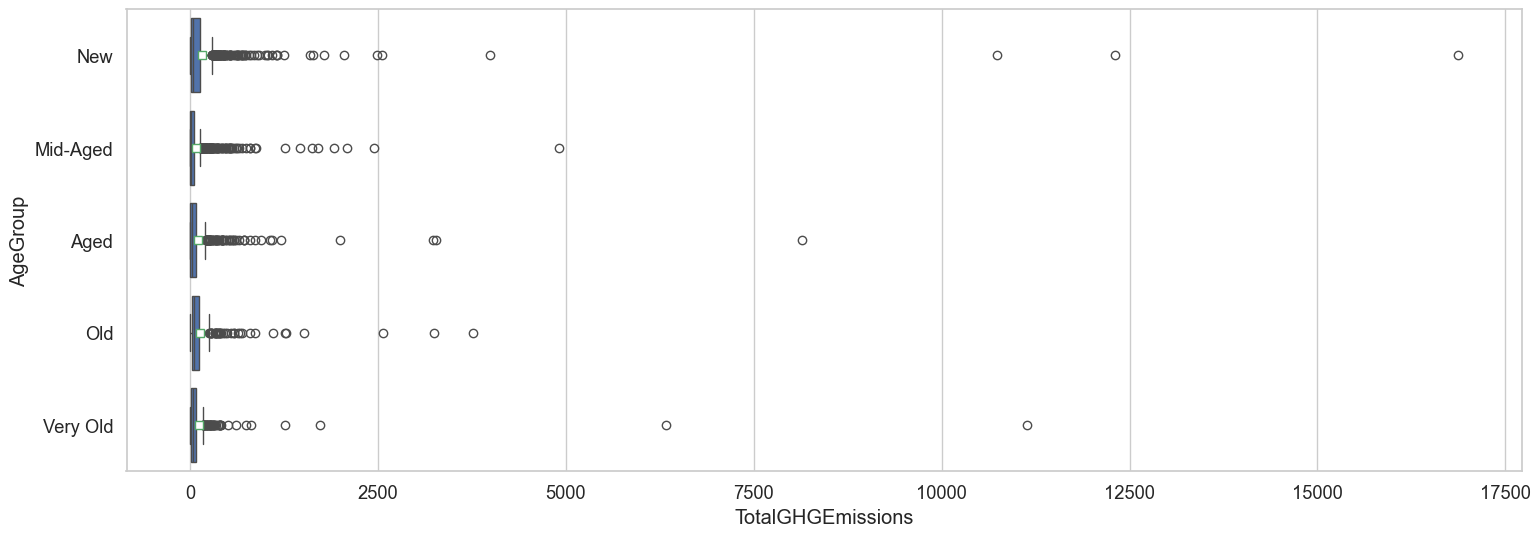

In [230]:
sns.boxplot(y=df_raw['AgeGroup'],
            x=df_raw['TotalGHGEmissions'],
            data=df_raw[df_raw['TotalGHGEmissions'] != np.nan],
            saturation=0.9,
            order=["New", "Mid-Aged", "Aged", "Old", 'Very Old'],
            showmeans=True,
            meanprops={
                "marker": "s",
                "markerfacecolor": "white"
            }
            #color='darkred'
            )

plt.show()

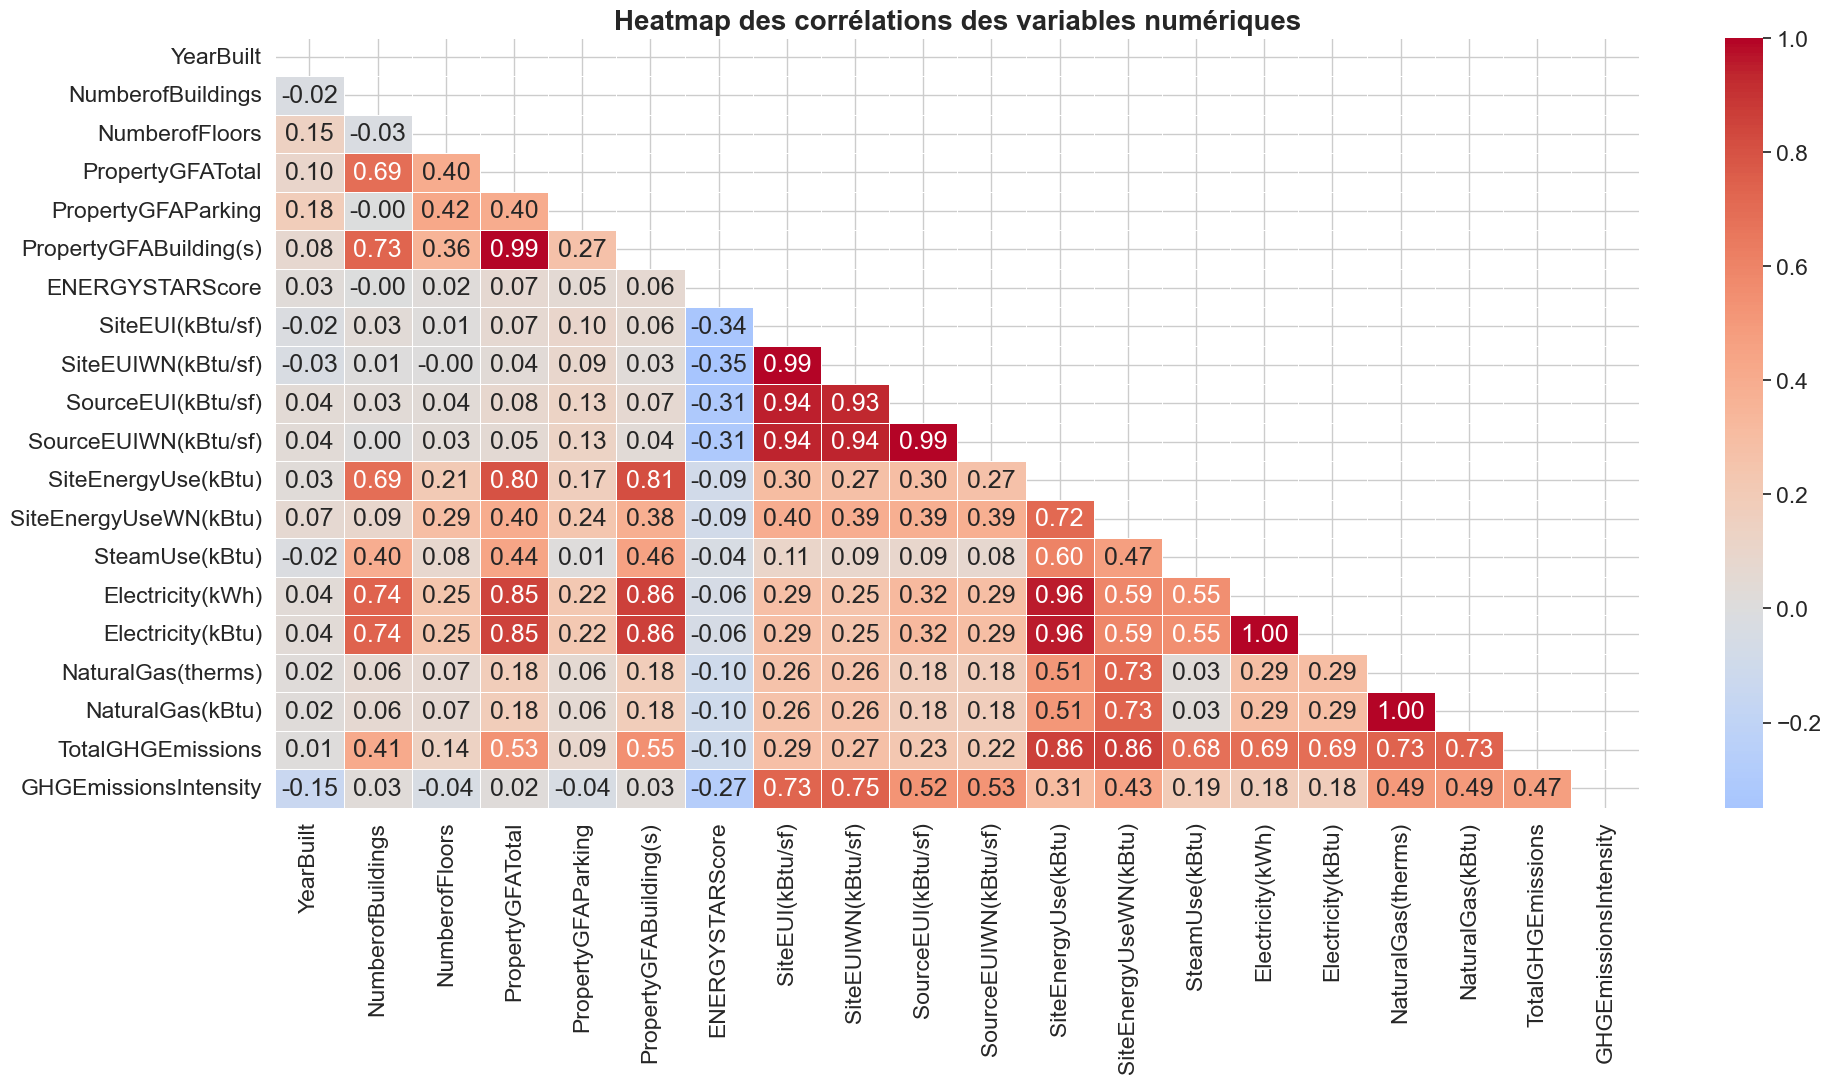

In [195]:
# Calculer la matrice de corrélation
corr_matrix = df_raw[numeric_vars].corr()

# Masque pour la partie supérieure
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Heatmap
plt.figure(figsize=(22, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    mask=mask,
    cmap='coolwarm',
    center=0,
    linewidths=0.7,
    fmt=".2f"
)
plt.title('Heatmap des corrélations des variables numériques', fontsize=20, fontweight='bold')
plt.show()


L’analyse des corrélations entre les variables numériques et la variable cible `TotalGHGEmissions` montre que certaines d’entre elles sont fortement liées aux émissions de gaz à effet de serre. En particulier, la consommation énergétique totale (`SiteEnergyUse(kBtu)`), la consommation d’électricité (`Electricity(kWh)`), le gaz naturel (`NaturalGas(therms)`) ainsi que la surface totale des bâtiments (`PropertyGFATotal` et `PropertyGFABuilding(s)`) présentent des corrélations élevées, supérieures à 0,5, ce qui indique qu’elles sont des facteurs déterminants des émissions. À l’inverse, des variables comme l’année de construction (`YearBuilt`) ou le nombre d’étages (`NumberofFloors`) montrent des corrélations faibles, suggérant un impact limité sur la variabilité des émissions totales. Ces résultats permettent d’orienter la sélection des variables explicatives pour les modèles de prédiction, tout en signalant la nécessité de gérer les redondances entre variables fortement corrélées, telles que différentes mesures de consommation énergétique.

# Section 4 : Analyse des variables qualitatives

### Description
Cette section réalise une **analyse univariée des variables catégorielles** du dataset de consommation énergétique et des émissions de CO₂ de Seattle.  
L'objectif est de **comprendre la distribution des catégories**, identifier les modalités dominantes et détecter d’éventuelles anomalies pour préparer le dataset pour le Machine Learning.

> **Philosophie :** "Explorer les catégories permet d’éviter les surprises dans le prétraitement et l’encodage des variables pour le modèle."

### Objectifs principaux
1. **Lister** toutes les variables catégorielles.
2. **Quantifier** le nombre de modalités uniques et les valeurs manquantes.
3. **Identifier** les modalités majoritaires et leur proportion.
4. **Visualiser** les distributions pour les variables clés.
5. **Préparer** un rapport synthétique pour guider l’encodage et la normalisation des variables catégorielles.

### Questions clés
* Combien de catégories uniques contient chaque variable ?
* Quelle est la catégorie la plus fréquente et sa proportion ?
* Existe-t-il des catégories très rares qui pourraient être regroupées ?

### Dépendances critiques
* `pandas`, `numpy` : Manipulation et analyse de données.
* `matplotlib`, `seaborn` : Visualisations graphiques.

### Livrables
1. **Tableau synthétique** des variables catégorielles avec nombre de modalités, valeurs manquantes, modalité majoritaire et proportion.  
2. **Graphiques** des distributions (Top 15 catégories) pour les variables clés.  
3. **Rapport PDF ou CSV** pour documentation et future préparation des données.

In [232]:
# Sélection des variables non numériques (qualitatives / catégorielles)
categorical_cols = df_raw.select_dtypes(exclude=[np.number]).columns.tolist()

# Affichage
categorical_cols


['BuildingType',
 'PrimaryPropertyType',
 'PropertyName',
 'Address',
 'City',
 'State',
 'TaxParcelIdentificationNumber',
 'Neighborhood',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'YearsENERGYSTARCertified',
 'DefaultData',
 'ComplianceStatus',
 'Outlier',
 'AgeGroup']

In [239]:
print(f"Nombre de variables quantitatives : {len(categorical_cols)}")

Nombre de variables quantitatives : 17


In [ ]:
# Variables qualitatives d'intérêt

vars_quali = ['BuildingType',
 'PrimaryPropertyType',
 'Neighborhood',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'YearsENERGYSTARCertified']

# Boucle sur chaque variable pour afficher un tableau stylé des modalités
for var in vars_quali:
    counts = df_raw[var].value_counts().head(12).to_frame()  # top 12 modalités
    counts.columns = [f'Count of {var}']  # renommer la colonne
    print("=" * 60)
    print(f"Modalités pour {var}")
    print("=" * 60)
    display(counts.style.background_gradient(cmap='Reds'))

Modalités pour BuildingType


,Count of BuildingType
BuildingType,
NonResidential,1460
Multifamily LR (1-4),1018
Multifamily MR (5-9),580
Multifamily HR (10+),110
SPS-District K-12,98
Nonresidential COS,85
Campus,24
Nonresidential WA,1


Modalités pour PrimaryPropertyType


,Count of PrimaryPropertyType
PrimaryPropertyType,
Low-Rise Multifamily,987
Mid-Rise Multifamily,564
Small- and Mid-Sized Office,293
Other,256
Warehouse,187
Large Office,173
K-12 School,139
Mixed Use Property,133
High-Rise Multifamily,105


Modalités pour Neighborhood


,Count of Neighborhood
Neighborhood,
DOWNTOWN,573
EAST,453
MAGNOLIA / QUEEN ANNE,423
GREATER DUWAMISH,375
NORTHEAST,280
LAKE UNION,251
NORTHWEST,210
SOUTHWEST,166
NORTH,145


Modalités pour ListOfAllPropertyUseTypes


,Count of ListOfAllPropertyUseTypes
ListOfAllPropertyUseTypes,
Multifamily Housing,866
"Multifamily Housing, Parking",464
Office,139
K-12 School,135
"Office, Parking",120
Non-Refrigerated Warehouse,101
Other,61
"Non-Refrigerated Warehouse, Office",61
Retail Store,56


Modalités pour LargestPropertyUseType


,Count of LargestPropertyUseType
LargestPropertyUseType,
Multifamily Housing,1667
Office,498
Non-Refrigerated Warehouse,199
K-12 School,139
Other,102
Retail Store,99
Hotel,77
Worship Facility,71
Distribution Center,54


Modalités pour SecondLargestPropertyUseType


,Count of SecondLargestPropertyUseType
SecondLargestPropertyUseType,
Parking,976
Office,215
Retail Store,155
Other,59
Restaurant,40
Non-Refrigerated Warehouse,33
Multifamily Housing,18
Fitness Center/Health Club/Gym,17
Supermarket/Grocery Store,14


Modalités pour ThirdLargestPropertyUseType


,Count of ThirdLargestPropertyUseType
ThirdLargestPropertyUseType,
Retail Store,110
Office,105
Parking,71
Restaurant,56
Other,49
Swimming Pool,29
Non-Refrigerated Warehouse,18
Medical Office,17
Data Center,14


Modalités pour YearsENERGYSTARCertified


,Count of YearsENERGYSTARCertified
YearsENERGYSTARCertified,
2016,14
20172016,8
2017,7
20162015,6
2014,6
2009,4
2013,4
201620152014,3
20172015,3


### Nuage de mots

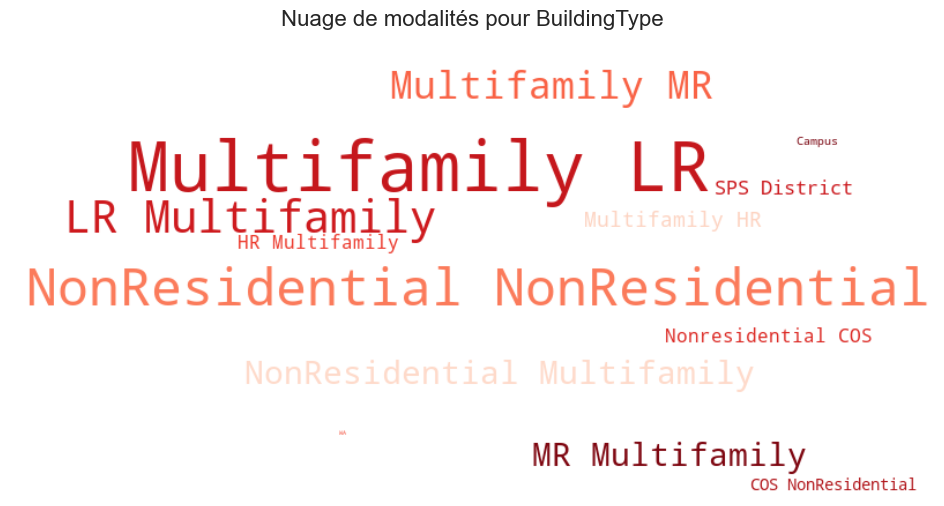

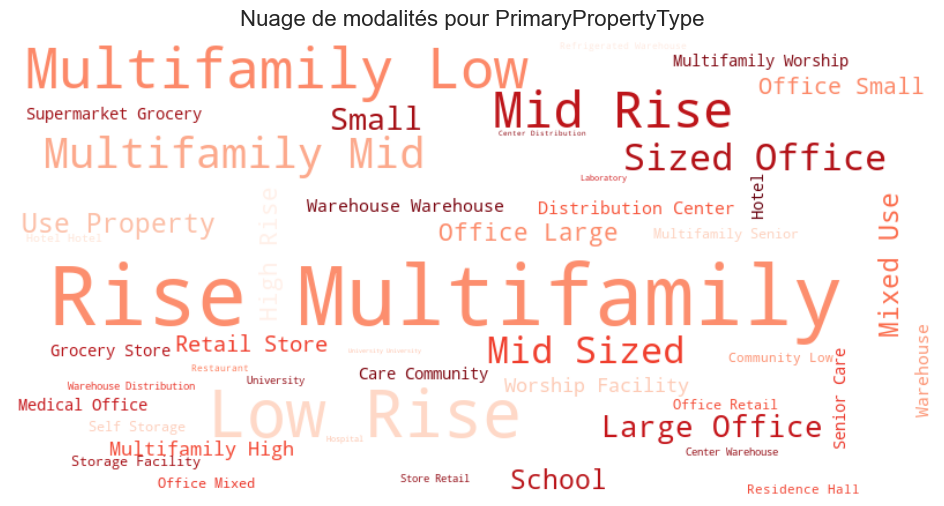

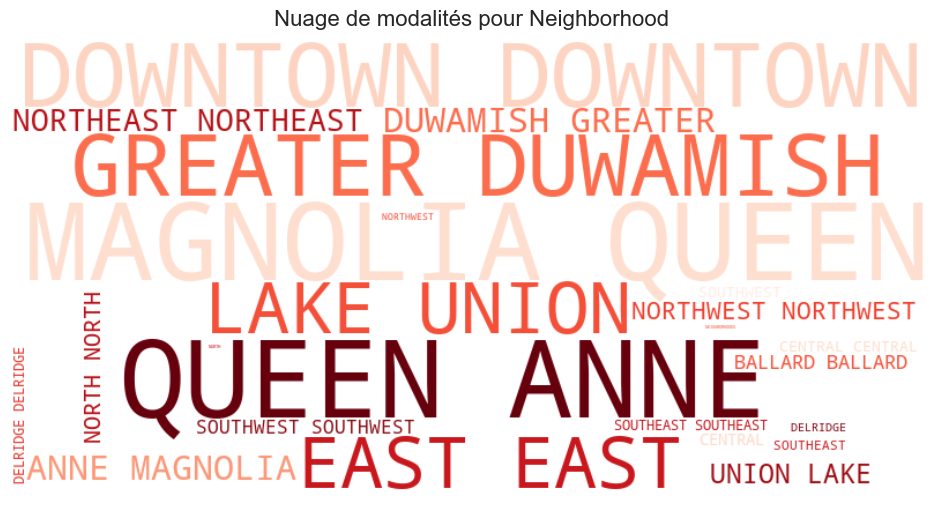

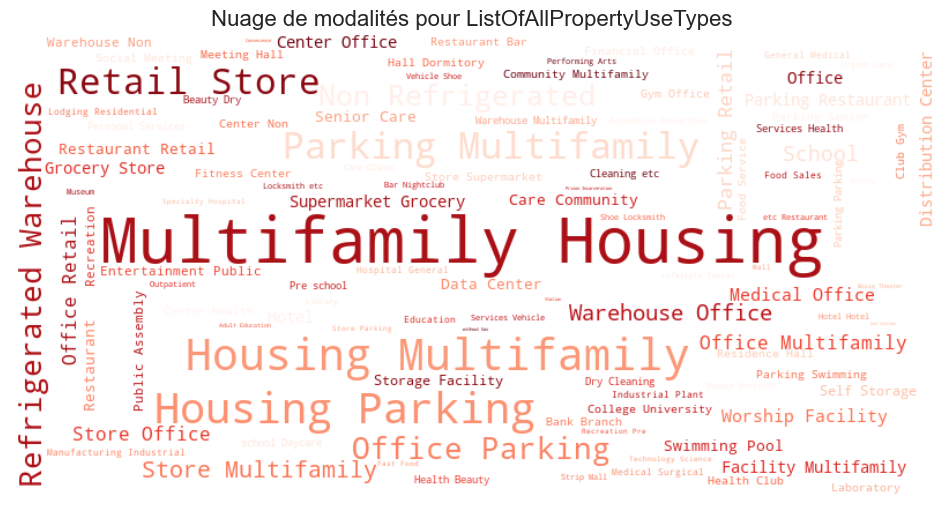

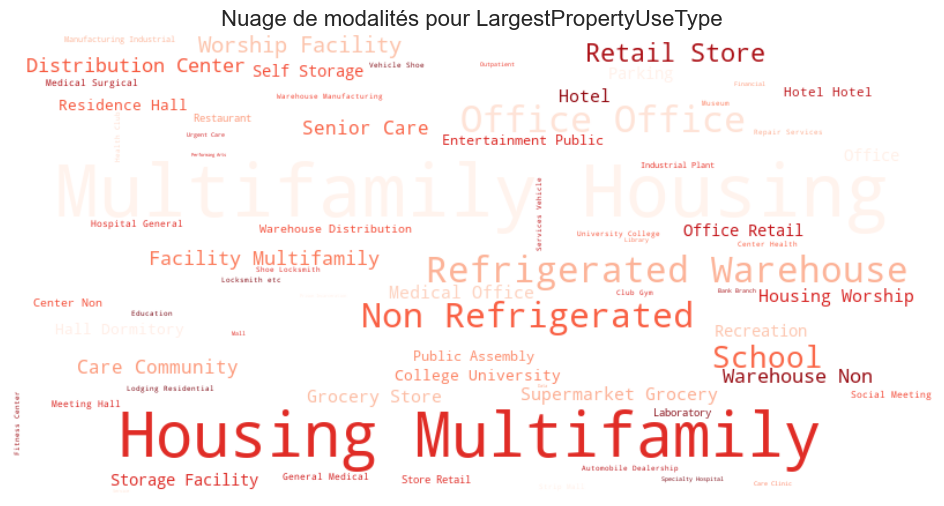

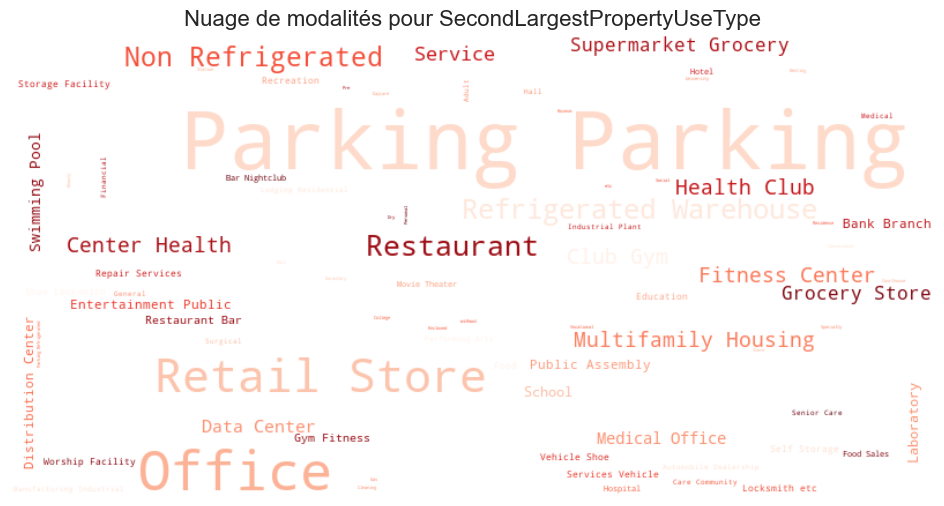

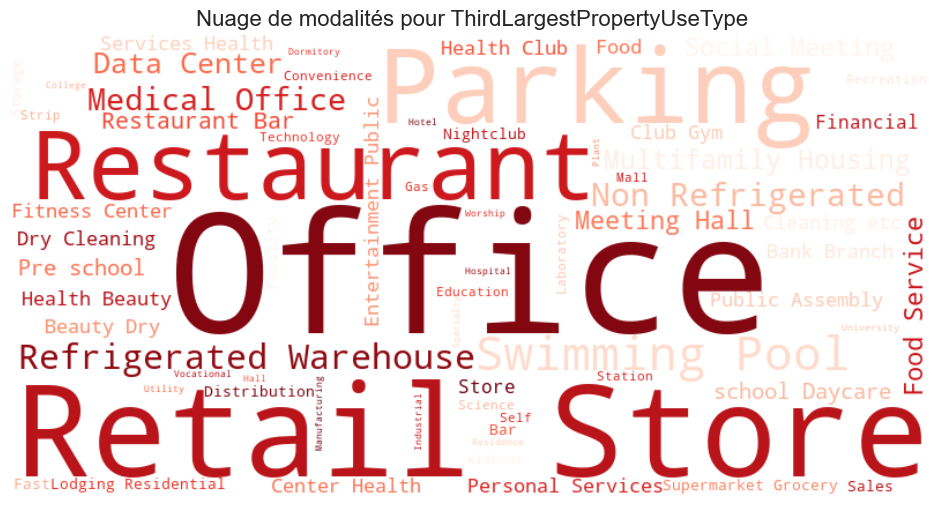

In [243]:
from wordcloud import WordCloud

# Variables qualitatives sélectionnées
vars_quali = [
    'BuildingType',
    'PrimaryPropertyType',
    'Neighborhood',
    'ListOfAllPropertyUseTypes',
    'LargestPropertyUseType',
    'SecondLargestPropertyUseType',
    'ThirdLargestPropertyUseType'
]

for var in vars_quali:
    # On retire les valeurs manquantes
    non_null_values = df_raw[var].dropna().astype(str)
    
    if len(non_null_values) == 0:
        print(f" La variable {var} est vide, aucun nuage généré.")
        continue  # passe à la variable suivante
    
    # Concaténer toutes les modalités en un seul texte
    text = " ".join(non_null_values)
    
    # Générer le wordcloud
    wordcloud = WordCloud(
        width=800, height=400, 
        background_color='white', 
        colormap='Reds'
    ).generate(text)
    
    # Affichage
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nuage de modalités pour {var}', fontsize=16)
    plt.show()


### Suite
Dans le prochain notebook 03_notebook nous allons réaliser l'analyse bivariée.